# TP Integrador N° 1 
#### Grupo 10

Integrantes:
- Rodrigo Gramajo
- Facundo Peloso
- Roberto Biancardi

Introducción

La inmobiliaria Properatti desea implementar un ***tasador automático*** para sus operaciones.

Nuestro objetivo final es desarrollar un modelo de regresión lineal que permita *predecir el* ***precio por metro cuadrado*** *de una propiedad.* Para ello, la empresa nos provee un dataset con los datos de sus operaciones en el primer semestre del 2017.

El alcance de este primer trabajo práctico es de leer, analizar y procesar dichos datos para desarrollar un modelo predictivo en próximos trabajos.



# 1 - Lectura de Datos y Análisis Primario

### 1.1 Lectura de Datos ###


Importamos las librerías que nos permitiran manejar y visualizar los datos

In [1]:
#Importacion de librerias/módulos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import collections
import descartes
import geopandas as gpd
from shapely.geometry import Point, polygon
import shapely.wkt
import plotly.express as px
import plotly as pl 

Leemos el archivo .csv que contiene al dataset y  hacemos una primera visualización.

NOTA: El archivo .csv esta ubicado en el mismo directorio que la notebook Main para evitar conflictos de distintas rutas locales.

In [2]:
#Establezco la dirección del archivo
file_location='properatti.csv'

#Leo el data set usando la librería pandas
# y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

#Visualizo las primeras filas
display(datos_crudos.head(3))

Unnamed: 0 operation property_type place_name  \
0           0      sell            PH  Mataderos   
1           1      sell     apartment   La Plata   
2           2      sell     apartment  Mataderos   

                       place_with_parent_names country_name  \
0        |Argentina|Capital Federal|Mataderos|    Argentina   
1  |Argentina|Bs.As. G.B.A. Zona Sur|La Plata|    Argentina   
2        |Argentina|Capital Federal|Mataderos|    Argentina   

               state_name  geonames_id                  lat-lon        lat  \
0         Capital Federal    3430787.0  -34.6618237,-58.5088387 -34.661824   
1  Bs.As. G.B.A. Zona Sur    3432039.0  -34.9038831,-57.9643295 -34.903883   
2         Capital Federal    3430787.0  -34.6522615,-58.5229825 -34.652262   

   ...  surface_covered_in_m2  price_usd_per_m2 price_per_m2  floor  rooms  \
0  ...                   40.0       1127.272727  1550.000000    NaN    NaN   
1  ...                    NaN               NaN          NaN    NaN    NaN   
2  ...                   55.0       1309.090909  1309.090909    NaN    NaN   

   expenses                                      properati_url  \
0       NaN  http://www.properati.com.ar/15bo8_venta_ph_mat...   
1       NaN  http://www.properati.com.ar/15bob_venta_depart...   
2       NaN  http://www.properati.com.ar/15bod_venta_depart...   

                                         description  \
0  2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...   
1  Venta de departamento en décimo piso al frente...   
2  2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...   

                                               title  \
0                 2 AMB TIPO CASA SIN EXPENSAS EN PB   
1  VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37   ...   
2           2 AMB 3ER PISO CON ASCENSOR APTO CREDITO   

                                     image_thumbnail  
0  https://thumbs4.properati.com/8/BluUYiHJLhgIIK...  
1  https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...  
2  https://thumbs4.properati.com/5/SXKr34F_IwG3W_...  

[3 rows x 26 columns]

### 1.2 Dimensiones del Dataset ###
Visualizamos la dimensión del dataset en filas *(Registros)* y columnas *(Campos)*:

In [3]:
#Imprimimos en pantalla la cantidad de filas y columnas
print('Tamaño del dataset')
print('Filas:',datos_crudos.shape[0])
print('Columnas:',datos_crudos.shape[1])

Tamaño del dataset
Filas: 121220
Columnas: 26


Hay mas 120 mil registro por lo que es de tamaño chico/mediano.

Cuenta con 26 campos para describir cada operacion inmobiliaria.

### 1.3 Analisis de los Campos ###

Listamos todos los campos del dataset y el tipo de dato que almacenan para entender que información nos brindan

In [4]:
#Instanciamos un Serie vacía
nombre_tipo_columnas=pd.Series()
#Utilizamos las columnas de nuestro dataset como índice de la serie vacía
# como valores guardamos el tipo de objeto almacenado en la primera fila de cada columna
for i in datos_crudos.columns : 
     nombre_tipo_columnas[i]=type(datos_crudos.loc[0,i])
nombre_tipo_columnas


C:\Users\fpeloso\AppData\Local\Temp\ipykernel_3936\1820039734.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  nombre_tipo_columnas=pd.Series()


Unnamed: 0                      <class 'numpy.int64'>
operation                               <class 'str'>
property_type                           <class 'str'>
place_name                              <class 'str'>
place_with_parent_names                 <class 'str'>
country_name                            <class 'str'>
state_name                              <class 'str'>
geonames_id                   <class 'numpy.float64'>
lat-lon                                 <class 'str'>
lat                           <class 'numpy.float64'>
lon                           <class 'numpy.float64'>
price                         <class 'numpy.float64'>
currency                                <class 'str'>
price_aprox_local_currency    <class 'numpy.float64'>
price_aprox_usd               <class 'numpy.float64'>
surface_total_in_m2           <class 'numpy.float64'>
surface_covered_in_m2         <class 'numpy.float64'>
price_usd_per_m2              <class 'numpy.float64'>
price_per_m2                

In [5]:
datos_crudos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

### 1.4 Listado y breve descripción de cada campo ###

- "Unnamed: 0": Es un campo que hace la función de índice. Cada registro es un valor numérico, entero, único y ordenado desde el 0 hasta el total de filas menos uno.

- "operation": String que define el tipo de operación: venta(sell) o alquiler(rent).

- property_type: String que define el tipo de propiedad (PH, Casa, Departamento)

- place_name: String que define el barrio/ciudad de la propiedad

- place_with_parent_names: String con diferentes datos geograficos separados por un caracter
 (pais, nombre, provincia, ciudad).

- country_name: String que define el país de la propiedad.

- state_name: String que indica la provincia/región de la propiedad.

- geonames_id: Corresponde a una base de daots externa que asigna un ID a una coordenada de lat-lon correspondiente a lugares geográficos(ciudades por ejemplo)

- lat-lon: Latitud y Longitud separados por un caracter.

- lat: Latidud de la propiedad.

- lon: Longitud de la propiedad.

- price: Precio en pesos

- currency: Moneda 

- price_aprox_local_currency: Precio en moneda local.

- price_aprox_usd: Precio aproximado en dólares

- surface_total_in_m2: Superficie total en metros cuadrados.

- surface_covered_in_m2: Superficie cubierta/bajo techo en metros cuadrados.

- price_usd_per_m2: Precio en dolar del metro cuadrado de la propiedad.

- price_per_m2: Precio en monedad local del metro cuadrado de la propiedad.

- floor: String que indica el piso en el que se encuentra el departamento o cantidad de pisos que tiene una casa.

- rooms: Cantidad de  ambientes que tiene la propiedad.

- expenses: Valor de las expensas.

- properati_url: URL del sitio web donde esta publicada la propiedad.

- description: Campo de texto con descripción detallada de la propiedad.

- title: Campo de texto con descripción más acotada de la propiedad.

- image_thumbnail: URL de una imagen de la propiedad.

### 1.5 Analisis de los campos del Dataset ###


##### Eliminación de campos: ####

Creamos una lista vacía donde iremos añadiendo los campos redundantes/ innecesarios que serán eliminados

In [6]:
#Lista vacía de campos a eliminar:
campos_a_eliminar=[]

**Unnamed 0:** - Esta columna no tiene ninguna utilidad o función ya que volcamos el dataset a un objeto Dataframe que ya cuenta con su propio índice. Por ende se descarta.

In [7]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('Unnamed: 0')

**Operation:** - Esta columna debería tener dos tipos de valores posibles (venta y alquiler). Podemos corrobar cuantos operaciones fueron venta y cuantas alquiler:

In [8]:
#Utilizamos el método value_counts para totalizar las operaciones de venta y alquier 
datos_crudos.operation.value_counts()

sell    121220
Name: operation, dtype: int64

Vemos que todas las operaciones realizadas han sido de ventas y ninguna de alquiler. Por lo tanto, esta columna no me aporta información y se descarta.

In [9]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('operation')

**country_name** - A priori se debería descartar ya que, por definición, partimos de la base que la inmobiliaria Properatti es una empresa argentina que opera solo en dicho país. No obstante, podemos corroborar si todos los registros del campo country_name coinciden y son efectivamente "Argentina":

In [10]:
#Utilizamos el método value_counts para totalizar los valores distinto que aparecen
#en la columna country_name
datos_crudos.country_name.value_counts()

Argentina    121220
Name: country_name, dtype: int64

Confirmamos que todos los registros tiene el mismo valor por lo que el campo no aporta información y se decarta la columna.

In [11]:
#añadimos el campo a la lista eliminar
campos_a_eliminar.append('country_name')

place_with_parent_names: Es un campo que contiene la misma información que place_name, state_name y country_name separados
por un caracter "|".

A priori, uno podría descartar esta columna y quedarse con las columnas que cuentan con los valores ya separados.

Sin embargo, vemos que place_name tiene registros nulos y place_with_parent_names no:

In [12]:
datos_crudos[['state_name','place_name','place_with_parent_names']].isnull().sum()

state_name                  0
place_name                 23
place_with_parent_names     0
dtype: int64

Por esto decidimos quedarnos con la ccolumna place_with_parent_names que tiene toda la mayor cantidad de información, 
a pesar que luego tendremos que procesarla.

Descartamos los campos state_name y place_name:

In [13]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('state_name','place_name'))

geonames_id: Corresponde a una base de datos que asigna latitud y longitud a ciudades, provincias y otras
entidades geográficas.

No es útil para imputar las columnas de latitud y longitud ya que si queremos analizar los precios de las propiedades por barrio, esto introduciría un sesgo a los datos y empeoraría el valor predictivo
de nuestro modelo. Por ende se descarta

In [14]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.append('geonames_id')


lat-lon: Tiene los datos de latitud y longitud separados por un caracter "-".
Podríamos descartala y utilizar las columnas lat y lon en su lugar. Pero primero corroboramos la calidad
de las columnas según cantidad de nulos:

In [15]:
#Vemos la cantidad de nulos en las columnas:
datos_crudos[['lat-lon','lat','lon']].isnull().sum()

lat-lon    51550
lat        51550
lon        51550
dtype: int64

Como tienen la misma cantidad de datos, descartamos la columna lat-lon.

In [16]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.append('lat-lon')

Ahora analizamos las columnas correspondientes al precio de las propiedades

Tenemos las columnas price (precio en dólares), currency(moneda en que se cotiza), 
price_aprox_local_currency (precio aproximado en pesos) y price_aprox_usd (precio aproximado en dólares)


Por un lado vemos que monedas se usaron para cotizar:

In [17]:
#Vemos cuantas monedas se utilizaron
datos_crudos.currency.value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

La gran mayoria de las cotizaciones fue en dólares. Deberíamos tener una única columna con el precio de las propiedades en dólares.

Ahora vemos si los precios en pesos han usado el mismo tipo de cambio:

In [18]:
#Creamos un dataframe dividiendo el precio aproximado en pesos por el precio aproximado en dólares
valor_de_cambio=datos_crudos.price_aprox_local_currency/datos_crudos.price_aprox_usd

#Vemos cuantas cotizaciones hubo
valor_de_cambio.value_counts()

17.6445    82402
17.6445      714
17.6445      670
17.6445      224
17.6445      224
           ...  
17.6445        1
17.6445        1
17.6445        1
17.6445        1
17.6445        1
Length: 7238, dtype: int64

Redondeamos los valores a cuatro decimales para verificar que son todos la misma conversión de peso/dolar

In [19]:
#Redondeamos el datafram a cuatro decimales y contamos valores nuevamente
valor_de_cambio=valor_de_cambio.round(4)
valor_de_cambio.value_counts()

17.6445    100809
dtype: int64

Analizamos los tres casos donde se utilizaron monedas que no son ni pesos ni dólares: PEN y UYU

In [20]:

#Primero filtramos los registros donde la moneda es 'PEN' y visualizamos que tiene en los campos correpondientes al precio
print('Los campos con monedas PEN son:')
display(datos_crudos.loc[datos_crudos.currency=='PEN'][['price','price_aprox_usd','price_aprox_local_currency','currency']])

#Tomo el indice de los registros para usar como iterador
Indice_PEN=datos_crudos.loc[datos_crudos.currency=='PEN'][['price_aprox_local_currency']].index
print('\nLa relación "precio moneda local/ precio en usd" es:')

#Imprimo la relacion para cada precio
for i in Indice_PEN:
    display(datos_crudos.loc[i,'price_aprox_local_currency']/datos_crudos.loc[i,'price_aprox_usd'])

#Ahora filtramos los registros donde la moneda es 'UYU' y visualizamos que tiene en los campos correpondientes al precio
print('\nLos campos con monedas UYU son:')
display(datos_crudos.loc[datos_crudos.currency=='UYU'][['price','price_aprox_usd','price_aprox_local_currency','currency']])

#Tomo el indice de los registros para usar como iterador
Indice_UYU=datos_crudos.loc[datos_crudos.currency=='UYU'][['price_aprox_local_currency']].index
print('\nLa relación "precio moneda local/ precio en usd" es:')

#Imprimo la relacion en precios 
display(datos_crudos.loc[Indice_UYU[0],'price_aprox_local_currency']/datos_crudos.loc[Indice_UYU[0],'price_aprox_usd'])


Los campos con monedas PEN son:


price  price_aprox_usd  price_aprox_local_currency currency
50387  380000.0        117139.33                  2066864.90      PEN
50388  950000.0        292848.33                  5167162.35      PEN


La relación "precio moneda local/ precio en usd" es:


17.644499930125942

17.64449997034301


Los campos con monedas UYU son:


price  price_aprox_usd  price_aprox_local_currency currency
107390  650000000.0      22980378.29                4.054773e+08      UYU


La relación "precio moneda local/ precio en usd" es:


17.644499999656013

Concluimos que esas monedas utilizadas (PEN y UYU) se debieron a errores de tipeo. La moneda local utilizada fueron
pesos argentinos.

Todas los precios tienen un tipo de cambio de 17,6445. 

Probablemente, se haya tomado el tipo de cambio
el dia de la fecha en que se exportó el dataset y se aplicó sobre los precios en dólares.

In [21]:
#Vemos la cantidad de nulos en los campos relativos al precio
datos_crudos[['price','price_aprox_local_currency','price_aprox_usd']].isnull().sum()

price                         20410
price_aprox_local_currency    20410
price_aprox_usd               20410
dtype: int64

Nos quedamos con la columna price_aprox_usd.

In [22]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('price','price_aprox_local_currency','currency'))

##### properati_URL e image_thumbnail: 
No tienen información numérica que podamos procesar para el análisis del precio por metro cuadrado. Por lo tantos los eliminamos

In [23]:
#añadimos los campos a la lista eliminar
campos_a_eliminar.extend(('properati_url','image_thumbnail'))

In [24]:
campos_a_eliminar

['Unnamed: 0',
 'operation',
 'country_name',
 'state_name',
 'place_name',
 'geonames_id',
 'lat-lon',
 'price',
 'price_aprox_local_currency',
 'currency',
 'properati_url',
 'image_thumbnail']

In [25]:
#Damos de baja las columnas 

datos= datos_crudos.drop(campos_a_eliminar, axis=1)

datos.head(3)

property_type                      place_with_parent_names        lat  \
0            PH        |Argentina|Capital Federal|Mataderos| -34.661824   
1     apartment  |Argentina|Bs.As. G.B.A. Zona Sur|La Plata| -34.903883   
2     apartment        |Argentina|Capital Federal|Mataderos| -34.652262   

         lon  price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
0 -58.508839          62000.0                 55.0                   40.0   
1 -57.964330         150000.0                  NaN                    NaN   
2 -58.522982          72000.0                 55.0                   55.0   

   price_usd_per_m2  price_per_m2  floor  rooms  expenses  \
0       1127.272727   1550.000000    NaN    NaN       NaN   
1               NaN           NaN    NaN    NaN       NaN   
2       1309.090909   1309.090909    NaN    NaN       NaN   

                                         description  \
0  2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...   
1  Venta de departamento en décimo piso al frente...   
2  2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...   

                                               title  
0                 2 AMB TIPO CASA SIN EXPENSAS EN PB  
1  VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37   ...  
2           2 AMB 3ER PISO CON ASCENSOR APTO CREDITO

### 1.6 Calidad de los datos en cada columna: 
#### Cantidad de valores nulos y no nulos

Creamos un dataframe donde ver la relación entre valores nulos y no-nulos en cada columna

In [26]:
#Creamos dos series donde guardamos los porcentajes de valores nulos y no nulos de cada campo
valores_nulos=datos.isnull().sum()/datos.shape[0]

valores_no_nulos=datos.notnull().sum()/datos.shape[0]

#Usando ambas series, instanciamos un dataframe
df_calidad_columnas=pd.DataFrame(dict(valores_no_nulos=valores_no_nulos,valores_nulos=valores_nulos))

df_calidad_columnas

valores_no_nulos  valores_nulos
property_type                    1.000000       0.000000
place_with_parent_names          1.000000       0.000000
lat                              0.574740       0.425260
lon                              0.574740       0.425260
price_aprox_usd                  0.831628       0.168372
surface_total_in_m2              0.675565       0.324435
surface_covered_in_m2            0.835778       0.164222
price_usd_per_m2                 0.566053       0.433947
price_per_m2                     0.723131       0.276869
floor                            0.065163       0.934837
rooms                            0.390942       0.609058
expenses                         0.117654       0.882346
description                      0.999984       0.000016
title                            1.000000       0.000000

### 1.7 Visualización Mediante Mapa de Calor

Utilizamos la herramienta heatmap para visualizar los registro nulos según cada columna y en posición del dataset se encuentra.

Su puede ver por ejemplo que el campo 'place_with_parent_names' no tiene casi ningun registro nulo.

Mientras que por otro lado, la columna 'expenses' tiene muy pocos datos.  

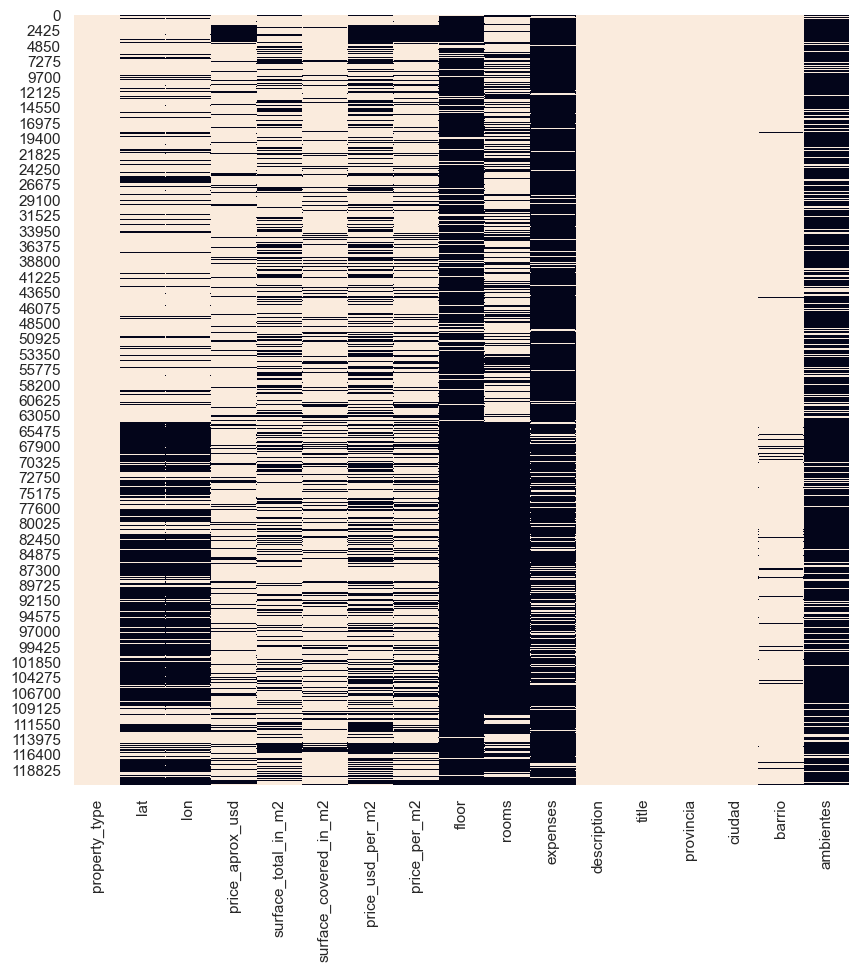

In [71]:
#Utilizamos la herramienta heatmap de la biblioteca seaborn
#Graficos el mapa de calor de los valores no nulos
sns.heatmap(datos.notnull(),cbar=False)
#Seteamos el tamaño de nuestro plot
sns.set(rc={'figure.figsize':(5,14)})

### 1.8 Visualizamos los totales de nulos y no nulos utilizando gráficos de barras.

C:\Users\fpeloso\AppData\Local\Temp\ipykernel_3936\348704519.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind, rotation = 90, ha="right")


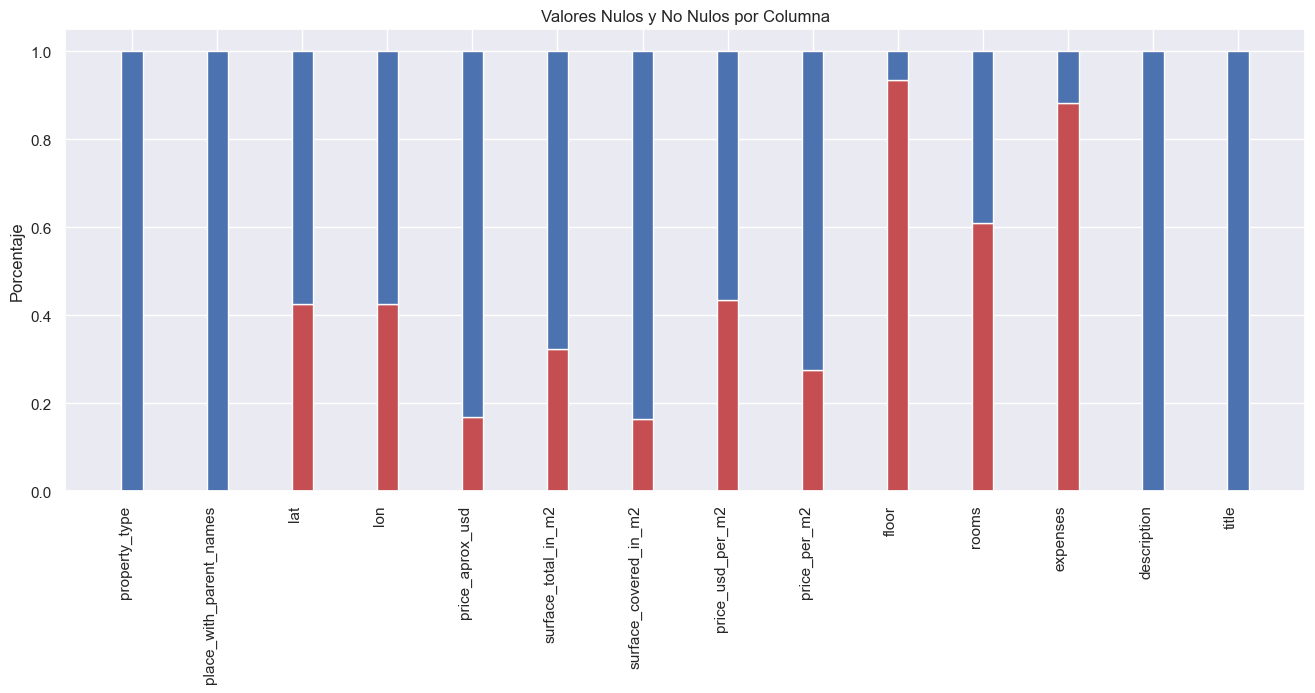

In [28]:
#Definimos un índice usando las columnas del dataset
ind=datos.columns

#Definimos un ancho para las barras
width = 0.25

#Creamos la figura y los ejes. Definimos tamaño de la figura
fig = plt.figure(figsize=(16,6)); ax = plt.axes()

#Graficamos valores nulos con color rojo
ax.bar(ind, valores_nulos, width, color='r') 
#Graficamos valores no nulos con color azul por debajo
ax.bar(ind, valores_no_nulos, width, color='b',bottom=valores_nulos)
 
#Indico etiquetas en eje X e Y
ax.set_ylabel('Porcentaje'); ax.set_title('Valores Nulos y No Nulos por Columna')
 
#Configuramos ticks
ax.tick_params(axis='both', which='minor', labelsize='small')
#Etiquetas de los campos a 90 grados
ax.set_xticklabels(ind, rotation = 90, ha="right")

plt.show()


# 2- Creación de Campos Nuevos

### 2.1 Columna "places_with_parent_names": 
#### Procesamos y extraemos información para crear nuevas columnas de ubicación geográfica 

In [29]:
#Creo un dataframe nuevo separando los campos de la columna places_with_parents
ubicacion = datos["place_with_parent_names"].str.split('|', expand=True) # Separo en varias columnas
#Visualizamos el dataframe creado:
ubicacion

0           1                             2              3  \
0          Argentina               Capital Federal      Mataderos   
1          Argentina        Bs.As. G.B.A. Zona Sur       La Plata   
2          Argentina               Capital Federal      Mataderos   
3          Argentina               Capital Federal        Liniers   
4          Argentina  Buenos Aires Costa Atlántica  Mar del Plata   
...    ..        ...                           ...            ...   
121215     Argentina               Capital Federal       Belgrano   
121216     Argentina      Bs.As. G.B.A. Zona Norte     San Isidro   
121217     Argentina               Capital Federal  Villa Urquiza   
121218     Argentina  Buenos Aires Costa Atlántica  Mar del Plata   
121219     Argentina               Capital Federal                  

                  4     5     6  
0                    None  None  
1                    None  None  
2                    None  None  
3                    None  None  
4            Centro        None  
...             ...   ...   ...  
121215               None  None  
121216       Beccar        None  
121217               None  None  
121218  Plaza Colón        None  
121219         None  None  None  

[121220 rows x 7 columns]

In [30]:
#Vemos cantidad de valores vacios/nulos en cada columna
for i in range(ubicacion.shape[1]):
    print('Porcentaje vacios en columna', i ,' :' ,ubicacion.iloc[:,i].isna().sum()/ubicacion.shape[0])


Porcentaje vacios en columna 0  : 0.0
Porcentaje vacios en columna 1  : 0.0
Porcentaje vacios en columna 2  : 0.0
Porcentaje vacios en columna 3  : 0.0
Porcentaje vacios en columna 4  : 0.03943243689160204
Porcentaje vacios en columna 5  : 0.6663916845405049
Porcentaje vacios en columna 6  : 0.9954792938459001


Columnas a eliminar:
- Columna 0 por ser un índice redundante 
- Columna 1 por tener el dato de País que ya decidimos descartar
- Columna 6 por su alta tasa de registros vacios.

In [31]:
#Creamos un df con las columnas de interes y el nombre de las columnas
ubicacion_limpia=ubicacion.drop([0,1,6],axis=1,inplace=False)
ubicacion_limpia.columns=['provincia','ciudad','barrio','barrio2']
ubicacion_limpia

provincia         ciudad       barrio barrio2
0                    Capital Federal      Mataderos                 None
1             Bs.As. G.B.A. Zona Sur       La Plata                 None
2                    Capital Federal      Mataderos                 None
3                    Capital Federal        Liniers                 None
4       Buenos Aires Costa Atlántica  Mar del Plata       Centro        
...                              ...            ...          ...     ...
121215               Capital Federal       Belgrano                 None
121216      Bs.As. G.B.A. Zona Norte     San Isidro       Beccar        
121217               Capital Federal  Villa Urquiza                 None
121218  Buenos Aires Costa Atlántica  Mar del Plata  Plaza Colón        
121219               Capital Federal                        None    None

[121220 rows x 4 columns]

#### Ahora vamos a imputar los datos de ciudad y barrio
Aquellos registros correspondientes a CABA tiene el campo de ciudad indicando un barrio de Capital Federal.


In [32]:
#Vemos la cantidad de registros nulos en barrio1 antes de imputar
print('La cantidad de registros nulos en barrio antes de imputar son:',ubicacion_limpia['barrio'].isnull().sum())

La cantidad de registros nulos en barrio antes de imputar son: 4780


In [33]:
#Utilizamos un método apply para que en aquellos registros donde la provincia es 'Capital Federal'
#Se guarde dicho valor en el campo 'ciudad' y el valor que estaba almacenado en esa columna, se guarde en barrio1

barrio_limpio=ubicacion_limpia.apply(lambda x: x['ciudad'] if x['provincia'] =='Capital Federal' else x['barrio'],axis=1)

#Visualizamos como quedo
barrio_limpio

0             Mataderos
1                      
2             Mataderos
3               Liniers
4                Centro
              ...      
121215         Belgrano
121216           Beccar
121217    Villa Urquiza
121218      Plaza Colón
121219                 
Length: 121220, dtype: object

Guardo la nueva columna con datos imputados en la columna barrio1 del dataset ubicacion_limpia

In [34]:
ubicacion_limpia['barrio']=barrio_limpio

Chequeamos la cantidad de registros nulos luego de la imputación con los barrios de Capital Federal:

In [35]:
print('La cantidad de registros nulos en barrio despues de imputar son:',ubicacion_limpia['barrio'].isnull().sum())

La cantidad de registros nulos en barrio despues de imputar son: 3483


Ahora imputamos la columna de ciudad, en aquellos registros donde la provincia se define como 'Capital Federal' también se debe definir la ciudad con ese valor

In [36]:
#Creamos un nuevo datafrane para los valores de ciudad que incluyan a capital federal
ciudad_limpia=ubicacion_limpia.apply(lambda x: x['provincia'] if x['provincia'] =='Capital Federal' else x['ciudad'],axis=1)

In [37]:
#añadimos el valor al dataframe ubicacion_limpia
ubicacion_limpia['ciudad']=ciudad_limpia
ubicacion_limpia['ciudad']

0         Capital Federal
1                La Plata
2         Capital Federal
3         Capital Federal
4           Mar del Plata
               ...       
121215    Capital Federal
121216         San Isidro
121217    Capital Federal
121218      Mar del Plata
121219    Capital Federal
Name: ciudad, Length: 121220, dtype: object

#### Ahora analizamos la columna barrio2

In [38]:
#Visualizamos los valores que hay en la columna barrio2
ubicacion_limpia.barrio2.value_counts()

                             39892
Barrio Los Alisos              278
Barrio La Alameda               62
BarrioPortezuelo                54
Barrio Los Lagos                39
Barrio El Golf                  32
Enyoi                           17
Barrio Los Castores             14
QBay Yacht                      13
Barrio La Isla                  10
Barrio Las Glorietas            10
Islas del Canal                  6
Barrio Barrancas del Lago        4
Barrio Los Sauces                4
Barrio Cabos del Lago            3
Barrio El Yacht                  1
Barrio Los Tilos                 1
Name: barrio2, dtype: int64

In [39]:
#Ademas de 40.000 registros vacios, hay mas de 80.000 registros nulos 
ubicacion_limpia.barrio2.isnull().sum()

80780

La columna tiene 40.000 registros vacíos y 80.000 registros nulos.

Vamos a tomar los registros no vacíos/nulos de barrio2 para imputar la columna de barrio1

In [40]:
#Creo una mascara para filtrar los registros vacío y nulos
mascara_barrio2 = ((ubicacion_limpia['barrio2']!='') & (ubicacion_limpia['barrio2'].notnull()))

#Aplicamos el filtro a la columna barrio 2 y vemos cuantos valores quedan
barrio_2_filtrado=ubicacion_limpia['barrio2'].loc[mascara_barrio2]

barrio_2_filtrado.value_counts()

Barrio Los Alisos            278
Barrio La Alameda             62
BarrioPortezuelo              54
Barrio Los Lagos              39
Barrio El Golf                32
Enyoi                         17
Barrio Los Castores           14
QBay Yacht                    13
Barrio Las Glorietas          10
Barrio La Isla                10
Islas del Canal                6
Barrio Barrancas del Lago      4
Barrio Los Sauces              4
Barrio Cabos del Lago          3
Barrio Los Tilos               1
Barrio El Yacht                1
Name: barrio2, dtype: int64

Primero vemos que hay en ciudad y barrio1 en aquellos registros que cuentan con algo en barrio2

In [41]:
#ahora veo que valores hay en barrio 1 cuando tengo algo en barrio2
print(ubicacion_limpia['barrio'].loc[mascara_barrio2].value_counts())

#ahora veo que valores hay en ciudad cuando tengo algo en barrio2
print(ubicacion_limpia['ciudad'].loc[mascara_barrio2].value_counts() )

Nordelta    548
Name: barrio, dtype: int64
Tigre    548
Name: ciudad, dtype: int64


Son todos barrios correspondientes a la ciudad de Tigre en la zona de Nordelta

Imputamos los valores faltantes de la columna barrio1 con aquellos presentes en barrio2

In [42]:
#Utilizo la mascara de barrio2 y guardo los valores que tenía filtrados
ubicacion_limpia.barrio.loc[mascara_barrio2]=barrio_2_filtrado

Corroboramos los valores que se imputaron en barrio

In [43]:
ubicacion_limpia.barrio.value_counts()

                                 47499
Palermo                           4083
Nordelta                          3315
Belgrano                          2992
Caballito                         2273
                                 ...  
Berazategui Oeste                    1
Elvira                               1
Marina Del Sol (Sun's Marine)        1
Sierras Bayas                        1
Alfar                                1
Name: barrio, Length: 634, dtype: int64

Damos de baja la columba barrio2, habiendo ya extraido toda la información que contenía

In [44]:
#Damos de baja la columna barrio2
ubicacion_limpia.drop('barrio2',axis=1, inplace=True)
ubicacion_limpia.sample(20)

provincia              ciudad           barrio
42801       Bs.As. G.B.A. Zona Norte               Tigre        Benavidez
43808                          Salta               Salta                 
89888       Bs.As. G.B.A. Zona Norte  General San Martín  Villa Ballester
113014               Capital Federal     Capital Federal             Once
57668   Buenos Aires Costa Atlántica       Mar del Plata                 
43935         Bs.As. G.B.A. Zona Sur             Quilmes           Bernal
83812                        Tucumán         Yerba Buena                 
13005                Capital Federal     Capital Federal          Palermo
41619       Bs.As. G.B.A. Zona Oeste               Morón         Castelar
52761       Bs.As. G.B.A. Zona Norte               Tigre         Nordelta
116826               Capital Federal     Capital Federal    Villa Urquiza
56167                Capital Federal     Capital Federal       Villa Luro
90705       Bs.As. G.B.A. Zona Norte       Vicente López          Florida
19472       Bs.As. G.B.A. Zona Oeste     Tres de Febrero          Caseros
37893                Capital Federal     Capital Federal             Boca
41354                        Córdoba          Mendiolaza                 
69582                Capital Federal     Capital Federal                 
87761                Capital Federal     Capital Federal        Chacarita
41771          Buenos Aires Interior        Bahía Blanca                 
62003       Bs.As. G.B.A. Zona Norte       Vicente López          Florida

#### Incorporamos los datos geográficos a nuestro dataset

In [45]:
#aca pruebo sumar las nuevas columnas a nuestro datos
datos[['provincia','ciudad','barrio']]=ubicacion_limpia

#### Damos de baja la columna 'place_with_parent_names'

In [46]:
#ahora hacemos drop de la columna place_with_parent_names, ya que ya extraímos su información
datos.drop('place_with_parent_names',axis=1, inplace=True)
datos.sample(3)


property_type        lat        lon  price_aprox_usd  \
104558     apartment        NaN        NaN         250000.0   
80255          house -34.751716 -58.394568         300000.0   
38962      apartment -32.892605 -60.692893              NaN   

        surface_total_in_m2  surface_covered_in_m2  price_usd_per_m2  \
104558                  NaN                   78.0               NaN   
80255                   NaN                  250.0               NaN   
38962                  51.0                   51.0               NaN   

        price_per_m2  floor  rooms  expenses  \
104558   3205.128205    NaN    NaN    4500.0   
80255    1200.000000    NaN    NaN       NaN   
38962            NaN    NaN    1.0       NaN   

                                              description  \
104558  NORDELTA, EL PALMAR, EDIFICIO INFINITY 2 - Exc...   
80255   MUY LINDO CHALET DE DOS PLANTAS, A METROS DE L...   
38962   ROZAS SERVICIOS INMOBILIARIOS :BV Rondeau / Na...   

                               title                 provincia  \
104558      Departamento - El Palmar  Bs.As. G.B.A. Zona Norte   
80255   Casa en Lomas de Zamora Este    Bs.As. G.B.A. Zona Sur   
38962             Departamento venta                  Santa Fe   

                 ciudad           barrio  
104558            Tigre         Nordelta  
80255   Lomas de Zamora  Lomas de Zamora  
38962           Rosario

#### Luego de haber agregado campos nuevos, volvemos a reivsar la calidad de las columnas

C:\Users\fpeloso\AppData\Local\Temp\ipykernel_3936\554242946.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ind, rotation = 90, ha="right")


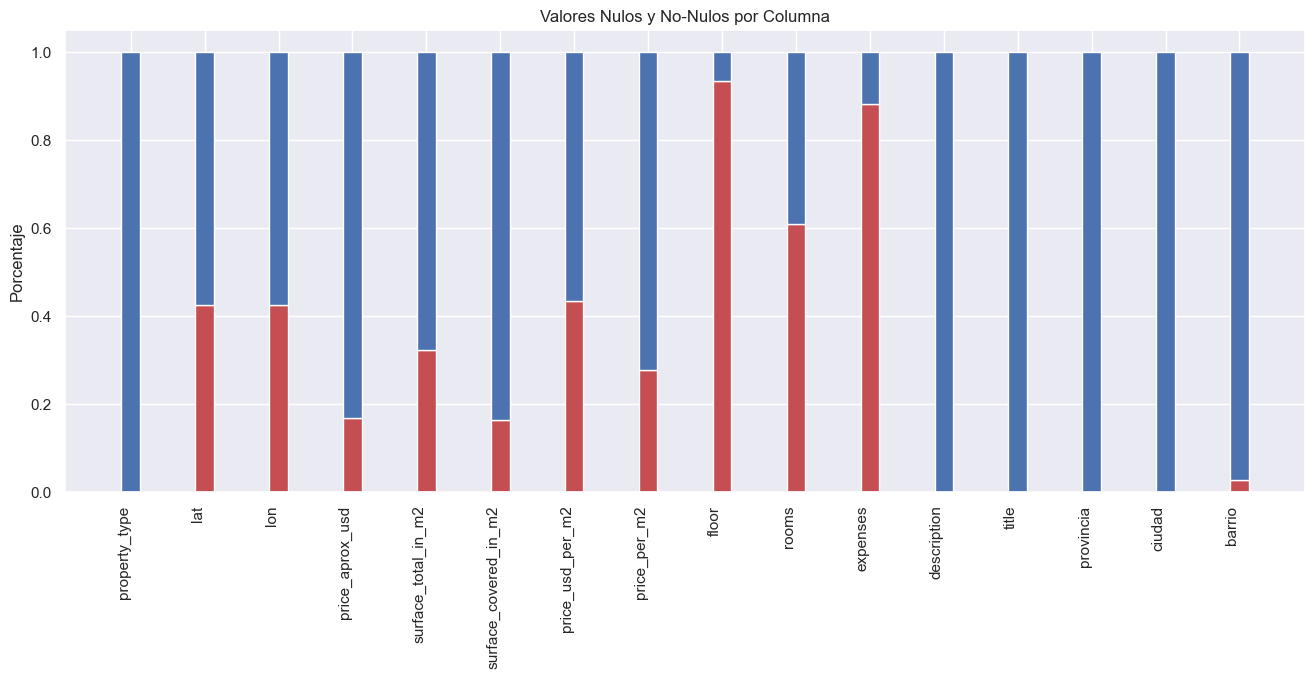

In [47]:
#Defino el indice segun las columnas
ind=datos.columns

#Calculo nuevamente los valores nulos y nulos en cada columna
valores_nulos=datos.isnull().sum()/datos.shape[0]
valores_no_nulos=datos.notnull().sum()/datos.shape[0]

#ancho de las barras
width = 0.25

fig = plt.figure(figsize=(16,6)); ax = plt.axes()

#grafico valores nulos con color rojo
ax.bar(ind, valores_nulos, width, color='r')  
#grafico valores no nulos con color azul por debajo
ax.bar(ind, valores_no_nulos, width, color='b',bottom=valores_nulos)

#Configuro labels de ejes
ax.set_ylabel('Porcentaje'); ax.set_title('Valores Nulos y No-Nulos por Columna')

#Configuramos ticks y ticklabels
ax.tick_params(axis='both', which='minor', labelsize='small')
ax.set_xticklabels(ind, rotation = 90, ha="right")

plt.show()

### 2.2 Columna "description":
#### Utilizamos métodos de regex para extraer información de este campo 

En cada caso se crea una nueve serie donde se almacena el texto del campo "description".

Sobre esta nueva serie se hace un apply para ejecutar el patron de regex correspondiente en cada caso.

#### Análisis de Campo Ambiente

In [48]:
# Guardo el texto en una nueva serie
SerieAmbiente = datos['description']
#Defino el patrón a buscar
patron_amb = '\d\s+[Aa]mbiente'
#Instancio el compile de regex con dicho patrón
patron_regex_amb = re.compile(patron_amb)

#Creo una nueva serie aplicando el patron de regex 
Ambiente = SerieAmbiente.apply(lambda x: np.NaN if len(patron_regex_amb.findall(str(x)))==0
                               else (patron_regex_amb.findall(str(x))[0])[0])
#Guardo la serie nueva en una columna de nuestro dataset
datos['ambientes'] = Ambiente

Revisamos la cantidad de no nulos en nuestra nueva columna:

In [49]:
print('La cantidad de  registros no nulos en ambientes es:', datos['ambientes'].notnull().sum())

La cantidad de  registros no nulos en ambientes es: 22328


Revisamos en cuales registros la columna 'rooms' no cuenta con datos y puede ser imputada por la columna 'ambientes':

In [50]:
#Creo una mascara donde 'ambientes' es no nulo y 'rooms' es nulo
mask_amb=datos['ambientes'].notnull() & datos['rooms'].isnull() 

In [51]:
#Contamos la cantidad de casos que devuelva la máscara
print('Se pueden imputar', mask_amb.sum(),' registros de "rooms" con "ambientes"')


Se pueden imputar 11559  registros de "rooms" con "ambientes"


In [137]:
datos['rooms'].notnull().sum()

58949

In [136]:
#Pasamos ambientes a float
datos['ambientes' ] = datos['ambientes'].astype(float)

# asignamos ambientes a rooms cuando ambientes es no-nulo y rooms es nulo
datos['rooms'] = datos.apply(lambda x: x['rooms'] if x['rooms'] > 0 else x['ambientes'], axis=1)

#Corroboramos cantidad de no nulos ahora
datos['rooms'].notnull().sum()

58949

#### Campo Cochera

In [ ]:
SerieCoch = datos['description']
patron_coch = '([Cc]ochera|[Gg]arage)'
patron_regex_coch = re.compile(patron_coch)
Cochera = SerieCoch.apply(lambda x: False if len(patron_regex_coch.findall(str(x)))==0 else True)
datos['cochera'] = Cochera

#### Campo Parrilla

In [ ]:
SerieParrilla = datos['description']
patron_parrilla = '[Pp]arrilla'
patron_regex_parrilla = re.compile(patron_parrilla)
Parrilla = SerieParrilla.apply(lambda x: False if len(patron_regex_parrilla.findall(str(x)))==0 else True)
datos['parrilla'] = Parrilla

#### Campo Patio

In [ ]:
SeriePatio = datos['description']
patron_patio = '[Pp]atio'
patron_regex_patio = re.compile(patron_patio)
Patio = SeriePatio.apply(lambda x: False if len(patron_regex_patio.findall(str(x)))==0 else True)
datos['patio'] = Patio

#### Campo Pileta

In [ ]:
SeriePileta = datos['description']
patron_pileta = '([Pp]ileta|[Pp]iscina)'
patron_regex_pileta = re.compile(patron_pileta)
Pileta = SeriePileta.apply(lambda x: False if len(patron_regex_pileta.findall(str(x)))==0 else True)
datos['pileta'] = Pileta

#### Campo Vista

In [ ]:
SerieVista = datos['description']
patron_vista = '([Aa]l\s[Ff]rente|[\s.,!/][Vv]istas*[\s.,!/)])'
patron_regex_vista = re.compile(patron_vista)
Vista = SerieVista.apply(lambda x: False if len(patron_regex_vista.findall(str(x)))==0 else True)
datos['vista'] = Vista

# 3 - Imputación de Campos

### 3.1 Columna price_usd_per_m2:
#### Vamos a tratar de imputar valores en esta columna

Cuando el valor de precio por metro cuadrado es nulo, se debe a que uno de los valores de superficie total y/o
precio en dólares es nulo.

Por lo tanto no se pueden utilizar esos campos para imputar la columna que nos interesa

In [125]:
# Creo un dataframe donde tengo los registro nulos de precio por metro cuadrado
datos_usdm2_null = datos[datos['price_usd_per_m2'].isnull()]

#### Definimos limites superiores e inferiores para outliers de precios y superficies

In [192]:
#defino limites de precio por metro cuadrado
lim_inf_precio_m2=500
lim_sup_precio_m2=6000

#defino limites de superficie
lim_inf_surface=10
lim_sup_surface=2000

In [134]:
# Cuando price_usd_per_m2 es nulo hay muchos registros completos en price_per_m2
# Tomamos sólo los que se encuentran entre 1000 y 6000 que hacen pensar que se cargaron en el campo equivocado
# Son 17.817 valores que llevarían los 52.603 nulos de price_usd_per_m2 a 34.786

#Creo una mascara para mi limite superior de precio
mask_sup = datos_usdm2_null['price_per_m2'] < lim_sup_precio_m2

#Creo una mascara para mi limite inferior de precio
mask_inf = datos_usdm2_null['price_per_m2'] > lim_inf_precio_m2

#Creo una serie donde guardo los valores de 'price_per_m2' cuando hay registros nulos en precio por metro cuadrado
#Ademas esta filtrado por las cotas inf y sup de precio
Serie_price_per_m2 = datos_usdm2_null[mask_sup & mask_inf]['price_per_m2']

#Utilizo esos datos para crear una nueva columna 'usd_per_m2_2'
datos['usd_per_m2_2'] = Serie_price_per_m2




#### Desde acá analizamos el nuevo campo usd_per_m2_2 que complementa a price_usd_per_m2

In [135]:
#Creo una mascara donde 'price_usd_per_m2' es nulo y mi nueva columna no lo es
mask_imputar = datos['price_usd_per_m2'].isnull() & datos['usd_per_m2_2'].notnull()

print(f'el campo price_usd_per_m2 cuenta con {datos.price_usd_per_m2.count()} datos no nulos')
print(f'el campo usd_per_m2_2  aporta {datos[mask_imputar].usd_per_m2_2.count()} valores no nulos al campo price_usd_per_m2')


el campo price_usd_per_m2 cuenta con 68617 datos no nulos
el campo usd_per_m2_2  aporta 19966 valores no nulos al campo price_usd_per_m2


In [139]:
datos['price_usd_per_m2'] = datos.apply(lambda x: x['price_usd_per_m2'] if x['price_usd_per_m2'] > 1 else x['usd_per_m2_2'], axis=1)

In [140]:
datos.price_usd_per_m2.notnull().sum()

88581

Vemos cuantas propiedades quedan por fuera de mis limites de outliers

In [141]:
#Mascara Inferior
mask_inf = datos.price_usd_per_m2 < lim_inf_precio_m2
print(f'En todo el país hay {datos[mask_inf].price_usd_per_m2.count()} propiedades de menos de ', lim_inf_precio_m2, 'usd x m2')

#Mascara Superior
mask_sup = datos.price_usd_per_m2 > lim_sup_precio_m2
print(f'En todo el país hay {datos[mask_sup].price_usd_per_m2.count()} propiedades de más de ', lim_sup_precio_m2,' usd x m2')

En todo el país hay 5333 propiedades de menos de  500 usd x m2
En todo el país hay 1489 propiedades de más de  6000  usd x m2


Visualizamos el top 7 de propiedades que son consideradas outliers, mostrando sus datos geográficos:

In [143]:
#Creo la mascara donde incluyo mis outliers
mask_outliers = (datos.price_usd_per_m2 < lim_inf_precio_m2) | (datos.price_usd_per_m2 > lim_sup_precio_m2)

#Agrupo por  los campos geográficos y cuento la cantidad de precios publicados
datos_outliers_usd = datos[mask_outliers].groupby(['provincia', 'ciudad', 'barrio', 'property_type']).agg({'price_usd_per_m2': 'count'})

#Los ordeno de mayor a menor y veo los primeros 7
datos_outliers_usd.sort_values('price_usd_per_m2', ascending=False).head(7)

price_usd_per_m2
provincia                    ciudad           barrio        property_type                  
Capital Federal              Capital Federal  Boedo         apartment                   403
Buenos Aires Costa Atlántica Mar del Plata                  house                       368
Bs.As. G.B.A. Zona Norte     Tigre            Benavidez     house                       264
Capital Federal              Capital Federal  Puerto Madero apartment                   218
                                              San Cristobal apartment                   193
Bs.As. G.B.A. Zona Norte     Pilar                          house                       177
Córdoba                      Villa Carlos Paz               house                       151

#### Ahora analizamos cada caso en particular

#### Caso Barrio de Boedo:

In [145]:
# Capital Federal | Capital Federal | Boedo | apartment con price_usd_per_m2 
# en el 100% de los cosas corresponden a proyectos desde el pozo 
# en casi todos los casos price_usd_per_m2 = price_per_m2 pero no guardan relación ni en $ ni en usd con 'description'
# vemos cuantos quedan entre 500 y 6000 usd en la misma zona paraa el mismo property_type
maskboedo = (datos.price_usd_per_m2 > lim_inf_precio_m2) & (datos.price_usd_per_m2 < lim_sup_precio_m2) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio == 'Boedo') & (datos.property_type == 'apartment')
datos[maskboedo].price_usd_per_m2.count() # quedan 357 en el dataset con las mismas características

357

In [147]:
# eliminamos entonces los 403 que no son consistentes
maskboedodrop = ((datos.price_usd_per_m2 < lim_inf_precio_m2) | (datos.price_usd_per_m2 > lim_sup_precio_m2)) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio == 'Boedo') & (datos.property_type == 'apartment')
listboedodrop = datos[maskboedodrop].index
datos = datos.drop(listboedodrop, axis=0)

#### Caso Mar del Plata:

In [148]:
# Buenos Aires Costa Atlántica | Mar del Plata |  | house con price_usd_per_m2 < 500 y mayor a 6000
# todos con precios en usd x m2 debajo de 500 - pudimos chequear con el campo description valores correctos de 309, 450 y 442
# maskMardel = (datos.index==9529)
# datos[maskMardel][['price_usd_per_m2', 'surface_total_in_m2']]
# eliminamos sólo los que tienen price_usd_per_m2 < 300 - 186 registros
maskMardel = (datos.price_usd_per_m2 < 300) &\
             (datos.provincia == 'Buenos Aires Costa Atlántica') & (datos.ciudad == 'Mar del Plata') &\
             (datos.property_type == 'house')
listMardeldrop = datos[maskMardel].index
datos = datos.drop(listMardeldrop, axis=0)

#### Caso San Cristobal:

In [150]:
# Capital Federal | Capital Federal | San Cristobal | apartment con price_usd_per_m2 < 500 y mayor a 6000
# en el 100% de los cosas corresponden a proyectos desde el pozo 
# en casi todos los casos price_usd_per_m2 = price_per_m2 pero no guardan relación ni en $ ni en usd con 'description'
# vemos cuantos quedan entre 500 y 6000 usd en la misma zona paraa el mismo property_type
maskSanCrist = (datos.price_usd_per_m2 > lim_inf_precio_m2) & (datos.price_usd_per_m2 < lim_sup_precio_m2) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio == 'San Cristobal') & (datos.property_type == 'apartment')
datos[maskSanCrist].price_usd_per_m2.count() # quedan 293 en el dataset con las mismas características

293

In [152]:
# eliminamos entonces los 193 que no son consistentes
maskSanCristdrop = ((datos.price_usd_per_m2 < lim_inf_precio_m2) | (datos.price_usd_per_m2 > lim_sup_precio_m2)) &\
             (datos.provincia == 'Capital Federal') & (datos.ciudad == 'Capital Federal') &\
             (datos.barrio == 'San Cristobal') & (datos.property_type == 'apartment')
listSanCristdrop = datos[maskSanCristdrop].index
datos = datos.drop(listSanCristdrop, axis=0)

#### Caso Pilar:

In [153]:
# BsAs. G.B.A. Zona Norte | Pilar | | house con price_usd_per_m2 < 500 y mayor a 6000
# las que están x debajo de 500 usd x m2 son todas reales muy afectadas por la superficie descubierta
# arriba de 6000 hay 3 que dropeamos
maskPilardrop = (datos.price_usd_per_m2 > lim_sup_precio_m2) &\
             (datos.provincia == 'Bs.As. G.B.A. Zona Norte') & (datos.ciudad == 'Pilar') &\
             (datos.property_type == 'house')
listPilardrop = datos[maskPilardrop].index
datos = datos.drop(listPilardrop, axis=0)

#### Caso Villa Carlos Paz:

In [154]:
# Córdoba | Villa Carlos Paz | | house con price_usd_per_m2 < 500 y mayor a 6000
# todas debajo de 500 usd x m2 y verificado valores de 100 a 200
# dropeamos sólo debajo de 100 usd x m2 porque parecen casas muy destruídas
maskCarlosdrop = (datos.price_usd_per_m2 < 100) &\
                 (datos.provincia == 'Córdoba') & (datos.ciudad == 'Villa Carlos Paz') &\
                 (datos.property_type == 'house')
listCarlosDrop = datos[maskCarlosdrop].index
datos = datos.drop(listCarlosDrop, axis=0)

#### Caso Pinamar:

In [155]:
# Buenos Aires Costa Atlántica | Pinamar | | house con price_usd_per_m2 < 500 y mayor a 6000
# Son todas debajo de 500 usd y pudimos verificar rangos de 200 a 500
# dropeamos debajo de 200
maskPinadrop = (datos.price_usd_per_m2 < 200) &\
                 (datos.provincia == 'Buenos Aires Costa Atlántica') & (datos.ciudad == 'Pinamar') &\
                 (datos.property_type == 'house')
listPinaDrop = datos[maskPinadrop].index
datos = datos.drop(listPinaDrop, axis=0)

#### Caso Rosario:

In [156]:
# Santa Fe | Rosario | | department con price_usd_per_m2 < 500 y mayor a 6000
# todos los vimos como errores < 500 no valida ninguno con 'description' > 6000 son emprendimientos desde el pozo y tampoco valida
maskRosario = (datos.price_usd_per_m2 > lim_inf_precio_m2) & (datos.price_usd_per_m2 < lim_sup_precio_m2) &\
             (datos.provincia == 'Santa Fe') & (datos.ciudad == 'Rosario') &\
             (datos.property_type == 'apartment')
datos[maskRosario].price_usd_per_m2.count() # quedan 3300 en el dataset con las mismas características

3300

In [157]:
# eliminamos entonces los 119 que no son consistentes
maskRosariodrop = ((datos.price_usd_per_m2 < lim_inf_precio_m2) | (datos.price_usd_per_m2 > lim_sup_precio_m2)) &\
             (datos.provincia == 'Santa Fe') & (datos.ciudad == 'Rosario') &\
             (datos.property_type == 'apartment')
listRosariodrop = datos[maskRosariodrop].index
datos = datos.drop(listRosariodrop, axis=0)

#### ahora vamos a tomar los outliers para eliminar tal queno estén en ninguna de las segmentaciones anteriores 
- para casas <200 y >6000
- para apartments <500 y >6000
- vemos para stores y phs a ver su distribución

In [159]:
maskRestoapartments =  ((datos.price_usd_per_m2 < lim_inf_precio_m2) | (datos.price_usd_per_m2 > lim_sup_precio_m2)) &\
                        (datos.property_type == 'apartment') &\
                        (datos.barrio != 'Boedo') & (datos.barrio != 'Puerto Madero') & (datos.barrio != 'San Cristobal') &\
                        (datos.ciudad != 'Rosario')
datos[maskRestoapartments].groupby(['provincia', 'ciudad', 'barrio']).aggregate({'price_usd_per_m2': 'count'})\
                            .sort_values(by='price_usd_per_m2', ascending=False)

price_usd_per_m2
provincia                    ciudad             barrio                          
Capital Federal              Capital Federal    Palermo                       91
                                                Belgrano                      39
Buenos Aires Costa Atlántica Miramar                                          32
Capital Federal              Capital Federal    Nuñez                         30
                                                                              26
...                                                                          ...
Bs.As. G.B.A. Zona Sur       La Plata                                          1
                             Ezeiza                                            1
                             Esteban Echeverría Canning                        1
                             Avellaneda         Villa Dominico                 1
Tucumán                      Yerba Buena                                       1

[136 rows x 1 columns]

In [160]:
listaRestoApartments = datos[maskRestoapartments].index
datos = datos.drop(listaRestoApartments, axis=0)

In [162]:
maskRestohouse =  ((datos.price_usd_per_m2 < 200) | (datos.price_usd_per_m2 > 6000)) &\
                        (datos.property_type == 'house') &\
                        (datos.ciudad != 'Mar del Plata') & (datos.ciudad != 'Pilar') & (datos.ciudad != 'Villa Carlos Paz') &\
                        (datos.ciudad != 'Pinamar') & (datos.barrio != 'Benavidez')
datos[maskRestohouse].groupby(['provincia', 'ciudad', 'barrio']).aggregate({'price_usd_per_m2': 'count'})\
                            .sort_values(by='price_usd_per_m2', ascending=False)

price_usd_per_m2
provincia                    ciudad          barrio                               
Córdoba                      Punilla                                            32
Bs.As. G.B.A. Zona Oeste     Moreno                                             29
Misiones                     Posadas                                            24
Bs.As. G.B.A. Zona Norte     Tigre                                              23
Buenos Aires Interior        Luján                                              23
...                                                                            ...
Bs.As. G.B.A. Zona Norte     Tigre           Ricardo Rojas                       1
Buenos Aires Costa Atlántica Cariló                                              1
Capital Federal              Capital Federal Belgrano                            1
                                             Almagro                             1
Bs.As. G.B.A. Zona Oeste     Moreno          St. Patrick Country                 1

[273 rows x 1 columns]

In [163]:
listaRestoHouse = datos[maskRestohouse].index
datos = datos.drop(listaRestoHouse, axis=0)

In [164]:
Nulos = datos['price_usd_per_m2'].isnull()
listaNulos = datos[Nulos].index
datos = datos.drop(listaNulos, axis=0)


In [165]:
datos = datos.drop('price_per_m2', axis=1)

In [166]:
datos = datos.drop('ambientes', axis=1)

In [167]:
datos = datos.drop('usd_per_m2_2', axis=1)

## 4- Visualización de Variables de Interés
### 4.1 Distribución de 'price_aprox_usd' y 'price_usd_per_m2':


<AxesSubplot:xlabel='price_usd_per_m2', ylabel='Count'>

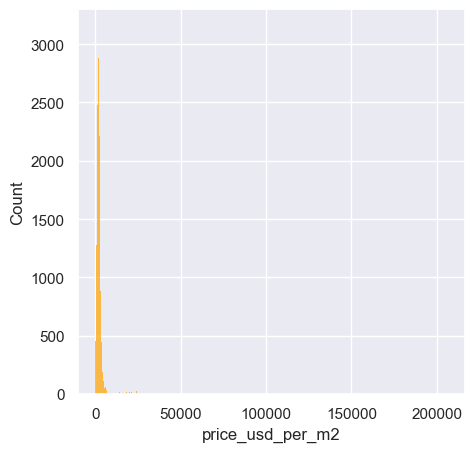

In [121]:
#Graficamos un histograma de precio por metro cuadrado
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(datos['price_usd_per_m2'], color = "orange",binwidth=100)

Si no se setea un limite en el eje X , no se puede visualizar la distribución debido a la presencia de outliers

Establecemos un limite de 10.000 en el eje X para poder ver la distribución mejor.

[(0.0, 10000.0)]

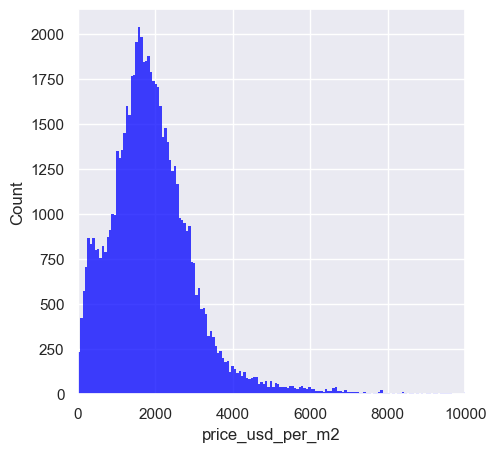

In [124]:
#Graficamos el histograma nuevamente
g2= sns.histplot(datos.price_usd_per_m2, color='blue')

#Limite de 10.000 al eje X
g2.set(xlim=(0,10000))

#### Visualizamos usando KDE

<AxesSubplot:xlabel='price_usd_per_m2', ylabel='Density'>

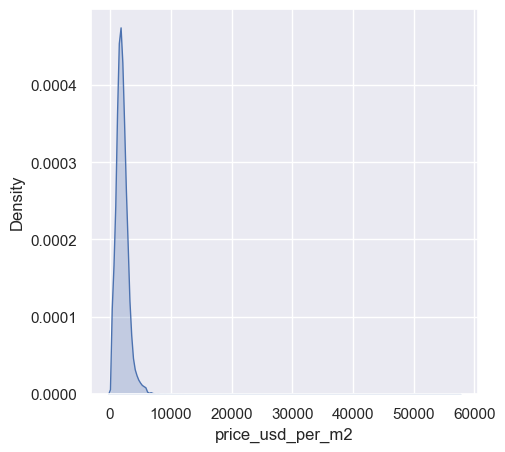

In [174]:
sns.kdeplot(datos.price_usd_per_m2, shade=True)

[(0.0, 10000.0)]

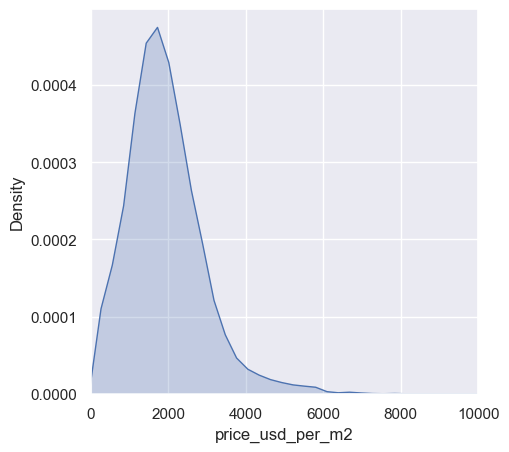

In [175]:
gkde=sns.kdeplot(datos.price_usd_per_m2, shade=True)
gkde.set(xlim=(0,10000))

Visualizamos la distribución de precio por metro cuadrado mediante un boxplot

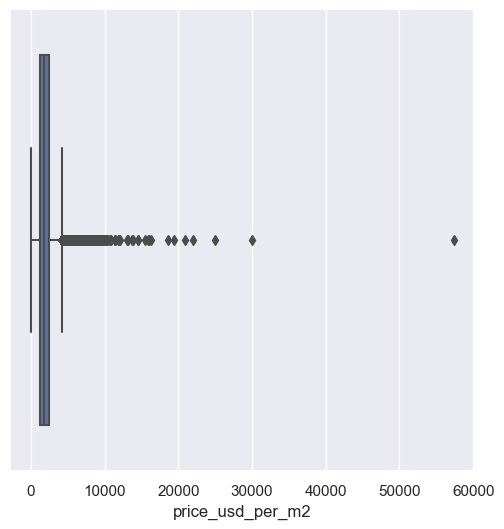

In [221]:
gbox_precio=sns.boxplot(x=datos.price_usd_per_m2)
gbox_precio=sns.set(rc={'figure.figsize':(6,6)})

Limitamos nuevamente el Eje X a 10.000 para mejor visualización

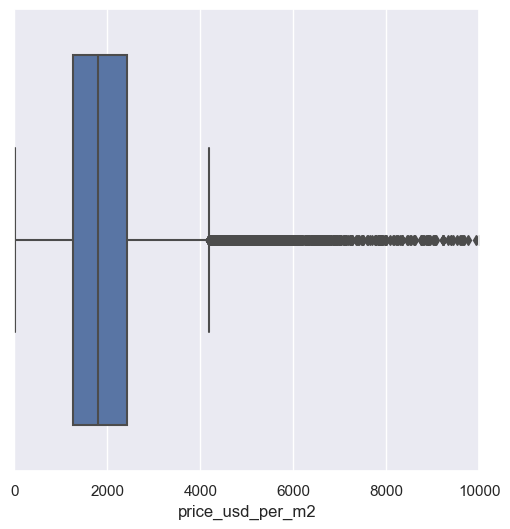

In [222]:
gbox_precio_filtrado=sns.boxplot(x=datos.price_usd_per_m2)
gbox_precio_filtrado.set(xlim=(0,10000))
gbox_precio_filtrado=sns.set(rc={'figure.figsize':(6,6)})

### 4.2 Estadísticas de Precio por Ubicación Geográfica

Filtramos las propiedades que no pertencen a CABA.
Agrupamos las propiedades segun provincia, ciudad y tipo de propiedad.
Visualizamos la media, desvio standard y cantidad de registros para cada grupo

Vamos el top 15 según cantidad de propiedades

In [171]:
masknoCap = datos['provincia'] != 'Capital Federal'
datos_agrup =datos[masknoCap].groupby(['provincia', 'ciudad', 'property_type']).agg({'price_usd_per_m2': ['mean', 'std', 'count'] })

datos_agrup.sort_values(('price_usd_per_m2', 'count'), ascending=False).round(0).head(15)


price_usd_per_m2  \
                                                                       mean   
provincia                    ciudad          property_type                    
Buenos Aires Costa Atlántica Mar del Plata   apartment               1977.0   
Bs.As. G.B.A. Zona Norte     Tigre           house                   1572.0   
                                             apartment               2399.0   
Santa Fe                     Rosario         apartment               1745.0   
Bs.As. G.B.A. Zona Norte     Vicente López   apartment               3066.0   
                             Pilar           house                   1246.0   
Córdoba                      Córdoba         apartment               1392.0   
Bs.As. G.B.A. Zona Norte     Escobar         house                   1177.0   
                             San Isidro      house                   1563.0   
Bs.As. G.B.A. Zona Sur       Lomas de Zamora house                   1344.0   
                                             apartment               2057.0   
Bs.As. G.B.A. Zona Norte     Vicente López   house                   1670.0   
                             San Isidro      apartment               2793.0   
Bs.As. G.B.A. Zona Oeste     Morón           apartment               1824.0   
Córdoba                                      apartment               1617.0   

                                                                         
                                                              std count  
provincia                    ciudad          property_type               
Buenos Aires Costa Atlántica Mar del Plata   apartment      539.0  4383  
Bs.As. G.B.A. Zona Norte     Tigre           house          776.0  4229  
                                             apartment      658.0  3577  
Santa Fe                     Rosario         apartment      511.0  3301  
Bs.As. G.B.A. Zona Norte     Vicente López   apartment      843.0  1929  
                             Pilar           house          650.0  1897  
Córdoba                      Córdoba         apartment      486.0  1537  
Bs.As. G.B.A. Zona Norte     Escobar         house          593.0  1459  
                             San Isidro      house          659.0  1436  
Bs.As. G.B.A. Zona Sur       Lomas de Zamora house          534.0  1271  
                                             apartment      491.0  1243  
Bs.As. G.B.A. Zona Norte     Vicente López   house          625.0  1098  
                             San Isidro      apartment      750.0  1091  
Bs.As. G.B.A. Zona Oeste     Morón           apartment      438.0  1051  
Córdoba                                      apartment      366.0  1047

Filtramos los barrios de CABA.
Agrupamos las propiedades segun barrio y tipo de propiedad.
Visualizamos la media, desvio standard y cantidad de registros para cada grupo

Vamos el top 15 según cantidad de propiedades

In [173]:
maskCap = datos['provincia'] == 'Capital Federal'
datos_agrup =datos[maskCap].groupby(['ciudad', 'barrio', 'property_type']).agg({'price_usd_per_m2': ['mean', 'std', 'count']})
datos_agrup.sort_values(('price_usd_per_m2', 'count'), ascending=False).round(0).head(15)

price_usd_per_m2              
                                                        mean     std count
ciudad          barrio        property_type                               
Capital Federal Palermo       apartment               3255.0   891.0  3030
                Belgrano      apartment               3102.0   763.0  2259
                Caballito     apartment               2466.0   495.0  1847
                Recoleta      apartment               3225.0   838.0  1289
                Villa Urquiza apartment               2537.0   445.0  1153
                San Telmo     apartment               2369.0   557.0  1044
                Flores        apartment               2073.0   385.0  1012
                Villa Crespo  apartment               2539.0   510.0   979
                Barrio Norte  apartment               2969.0   840.0   918
                Almagro       apartment               2245.0   487.0   823
                Nuñez         apartment               3059.0   827.0   580
                Balvanera     apartment               1943.0   463.0   546
                Puerto Madero apartment               5997.0  1351.0   518
                Monserrat     apartment               2174.0   518.0   432
                              house                    950.0   562.0   419

#### Precio por m2 Promedio por Provincia

Vemos como varía el precio promedio según cada provincia

In [179]:
# Creamos un nuevo dataframe con los columnas de precio y provincia
precio_por_provincia=datos[['price_usd_per_m2','provincia']]

#Las agrupamos y usamos la función de agregación de la media
precio_medio_por_provincia=precio_por_provincia.groupby('provincia').mean().round(0).sort_values(by='price_usd_per_m2',ascending=False)
print("Vemos el precio promedio por provincia ordenado de mayor a menor:")
display(precio_medio_por_provincia)


Vemos el precio promedio por provincia ordenado de mayor a menor:


price_usd_per_m2
provincia                                     
San Juan                                3191.0
Catamarca                               2634.0
Capital Federal                         2563.0
Río Negro                               2024.0
Bs.As. G.B.A. Zona Norte                1847.0
Neuquén                                 1802.0
Buenos Aires Costa Atlántica            1658.0
Santa Fe                                1648.0
Chubut                                  1616.0
Bs.As. G.B.A. Zona Sur                  1554.0
Formosa                                 1510.0
Mendoza                                 1510.0
Jujuy                                   1498.0
Corrientes                              1484.0
Bs.As. G.B.A. Zona Oeste                1445.0
Buenos Aires Interior                   1410.0
Córdoba                                 1306.0
La Pampa                                1252.0
Tierra Del Fuego                        1197.0
Entre Ríos                              1185.0
San Luis                                1178.0
Salta                                   1130.0
Chaco                                   1111.0
Misiones                                 999.0
Tucumán                                  941.0
Santa Cruz                               745.0
La Rioja                                 394.0
Santiago Del Estero                      369.0

#### Ahora visualizamos la distribución en cada provincia usando boxplots 


Primero con los datos sin filtrar:

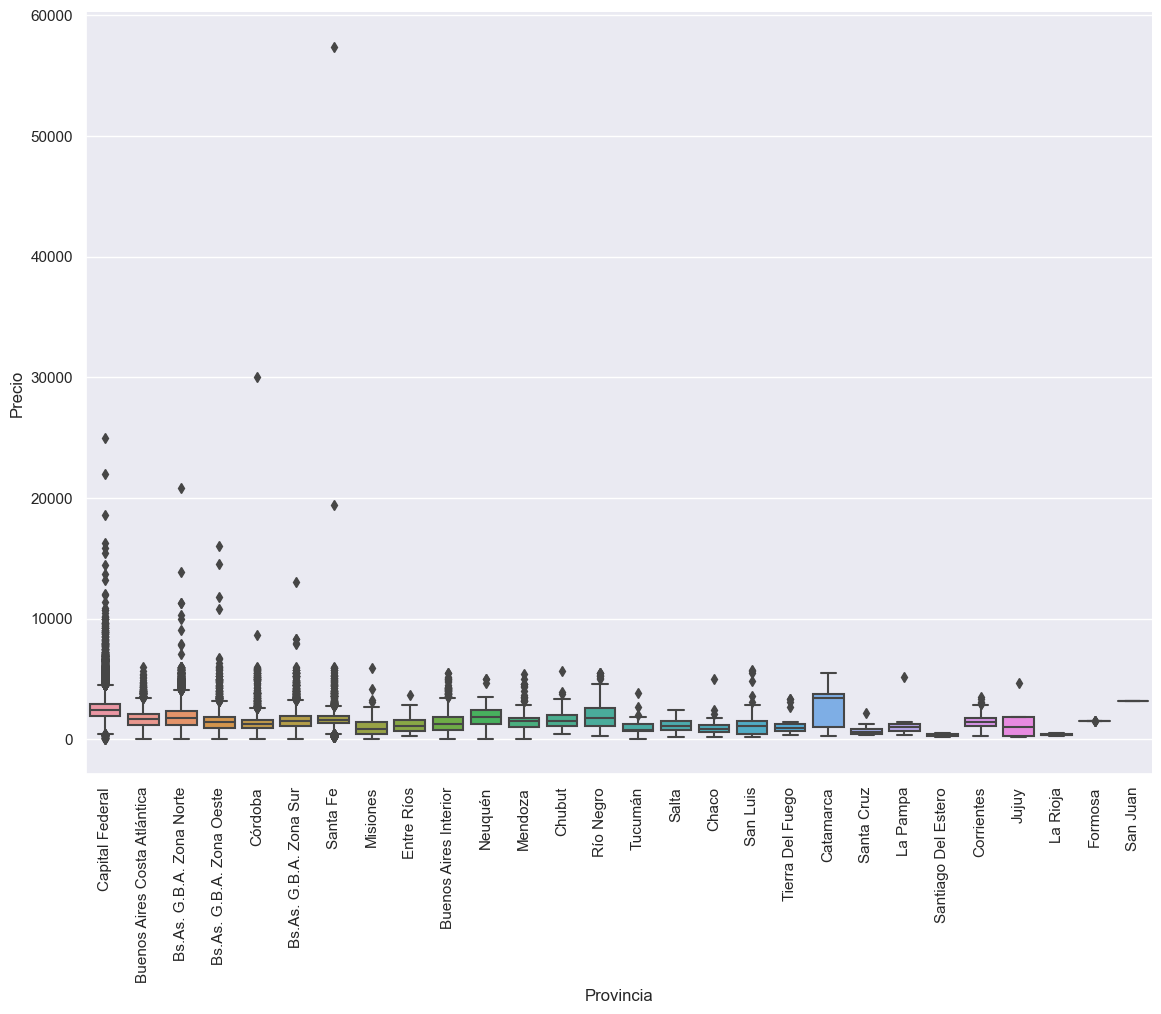

In [223]:
#Graficamos boxplot de cada provincia
g_box_prov = sns.catplot(x = "provincia", y = "price_usd_per_m2", data=precio_por_provincia, kind="box",height=8.27, aspect=11.7/8.27)
g_box_prov.set_axis_labels("Provincia", "Precio")  
g_box_prov.set_xticklabels(rotation=90) 

Ahora filtramos los precios por m2 menores a 10.000

In [224]:
#Creo un dataframe con los precio filtrados
precio_provincia_filtrado=precio_por_provincia.loc[precio_por_provincia['price_usd_per_m2']<lim_sup_precio_m2]

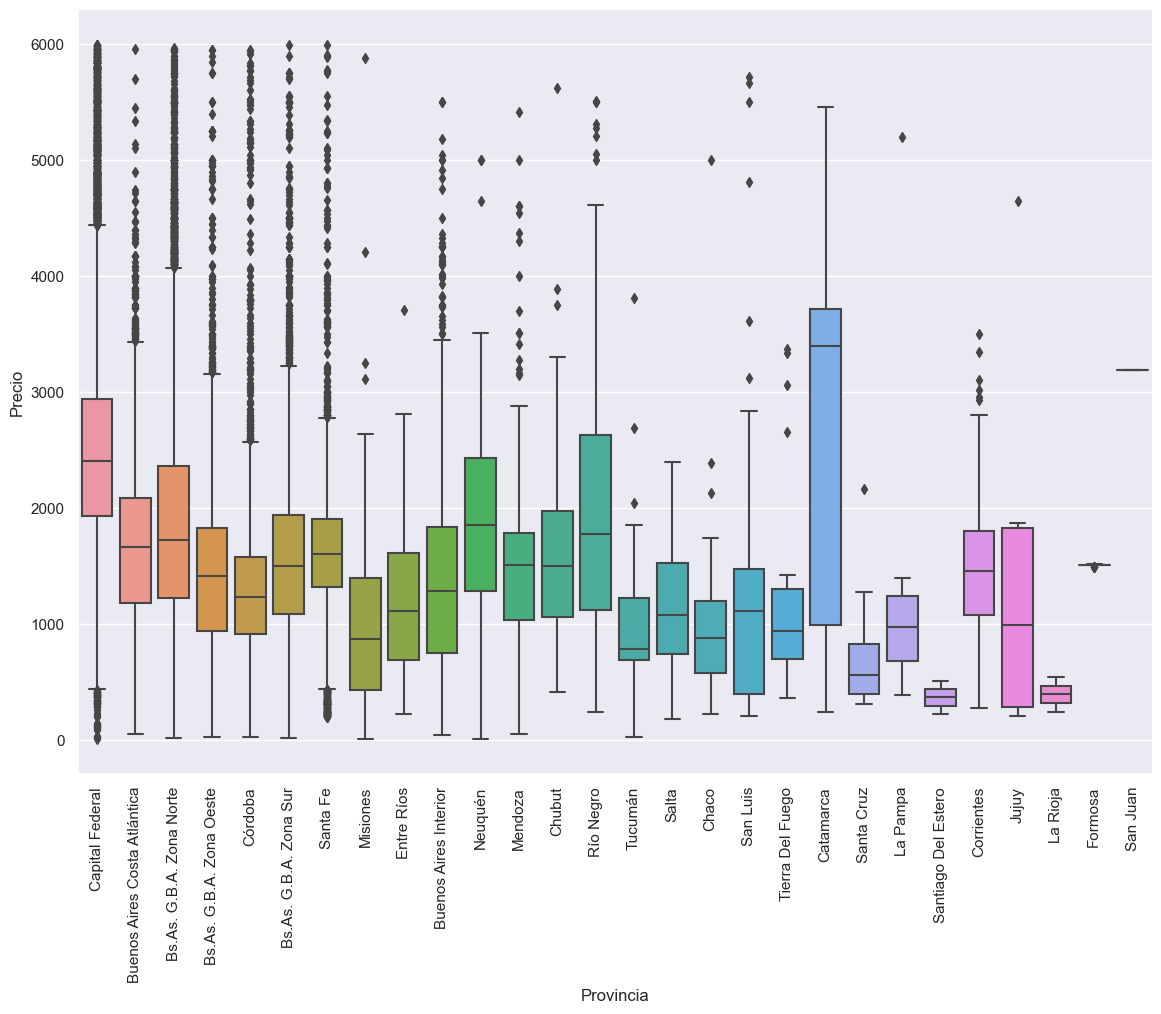

In [225]:
#Graficamos boxplot de cada provincia
g_box_prov_filtrada = sns.catplot(x = "provincia", y = "price_usd_per_m2", data=precio_provincia_filtrado, kind="box",height=8.27, aspect=11.7/8.27)
g_box_prov_filtrada.set_axis_labels("Provincia", "Precio")  
g_box_prov_filtrada.set_xticklabels(rotation=90) 

#### Precio por m2 Promedio por Barrio en CABA

In [184]:
# Creamos un nuevo dataframe con los columnas de precio y provincia
precio_por_barrio_caba=datos.loc[datos['ciudad']=='Capital Federal'][['price_usd_per_m2','barrio']]

#Las agrupamos y usamos la función de agregación de la media
precio_medio_por_barrio_caba=precio_por_barrio_caba.groupby('barrio').mean().round(0).sort_values(by='price_usd_per_m2',ascending=False)
print("Vemos el precio promedio por metro cuadrado por barrio ordenado de mayor a menor:")
display(precio_medio_por_barrio_caba)


Vemos el precio promedio por metro cuadrado por barrio ordenado de mayor a menor:


price_usd_per_m2
barrio                                
Puerto Madero                   5964.0
Las Cañitas                     3438.0
Recoleta                        3293.0
Palermo                         3230.0
Belgrano                        3068.0
Barrio Norte                    3011.0
Nuñez                           2988.0
Retiro                          2885.0
Colegiales                      2553.0
Villa Crespo                    2518.0
Villa Urquiza                   2477.0
Coghlan                         2470.0
Catalinas                       2438.0
Centro / Microcentro            2430.0
Caballito                       2420.0
Saavedra                        2395.0
San Telmo                       2314.0
Villa Ortuzar                   2298.0
Parque Centenario               2280.0
San Nicolás                     2257.0
Parque Chas                     2250.0
Chacarita                       2238.0
Villa del Parque                2211.0
Almagro                         2206.0
Monserrat                       2168.0
Tribunales                      2160.0
Villa Devoto                    2132.0
San Cristobal                   2098.0
Villa Pueyrredón                2086.0
Once                            2084.0
Abasto                          2081.0
Villa Santa Rita                2071.0
Agronomía                       2068.0
Villa Luro                      2056.0
Flores                          2039.0
Boedo                           1997.0
Balvanera                       1933.0
Versalles                       1921.0
Barracas                        1898.0
Paternal                        1897.0
Congreso                        1894.0
Monte Castro                    1893.0
Villa General Mitre             1845.0
Parque Patricios                1827.0
Liniers                         1820.0
Floresta                        1791.0
Constitución                    1759.0
Parque Chacabuco                1743.0
                                1694.0
Villa Real                      1611.0
Boca                            1593.0
Velez Sarsfield                 1573.0
Mataderos                       1556.0
Parque Avellaneda               1555.0
Pompeya                         1291.0
Villa Lugano                    1268.0
Villa Riachuelo                 1187.0
Villa Soldati                    879.0

#### Ahora visualizamos la distribución en cada barrio usando boxplots 
 Usando distintos filtros para los outliers 

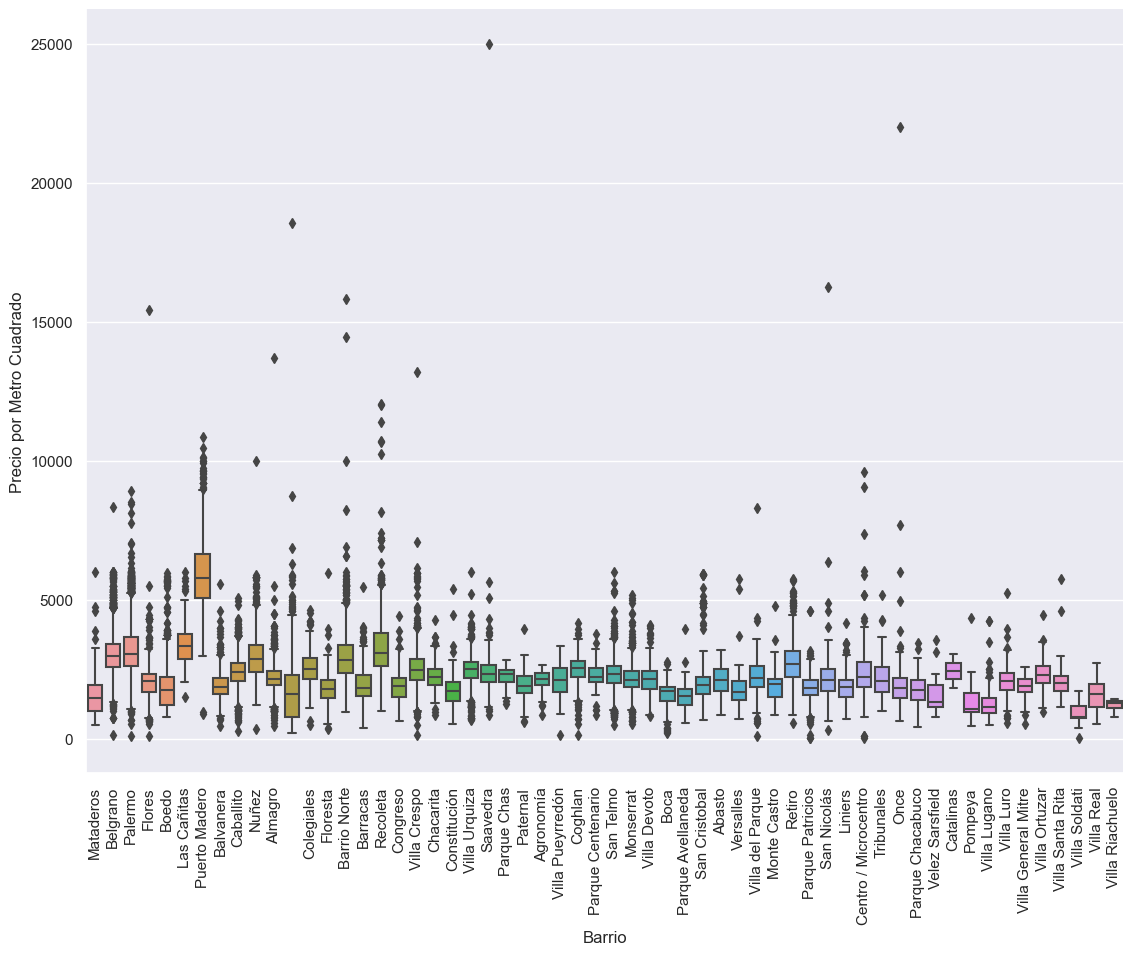

In [226]:
#Graficamos boxplot de cada barrio de CABA
g_box_barrio_caba = sns.catplot(x = "barrio", y = "price_usd_per_m2", data=precio_por_barrio_caba, kind="box",height=8.27, aspect=11.7/8.27)
g_box_barrio_caba.set_axis_labels("Barrio", "Precio por Metro Cuadrado")  
g_box_barrio_caba.set_xticklabels(rotation=90) 

Ahora aplicamos filtros para remover outliers

In [187]:
#Creo un dataframe con los precio filtrados
#lim_sup_precio=500000
precio_barrio_caba_filtrado=precio_por_barrio_caba.loc[precio_por_barrio_caba['price_usd_per_m2']<lim_sup_precio_m2]

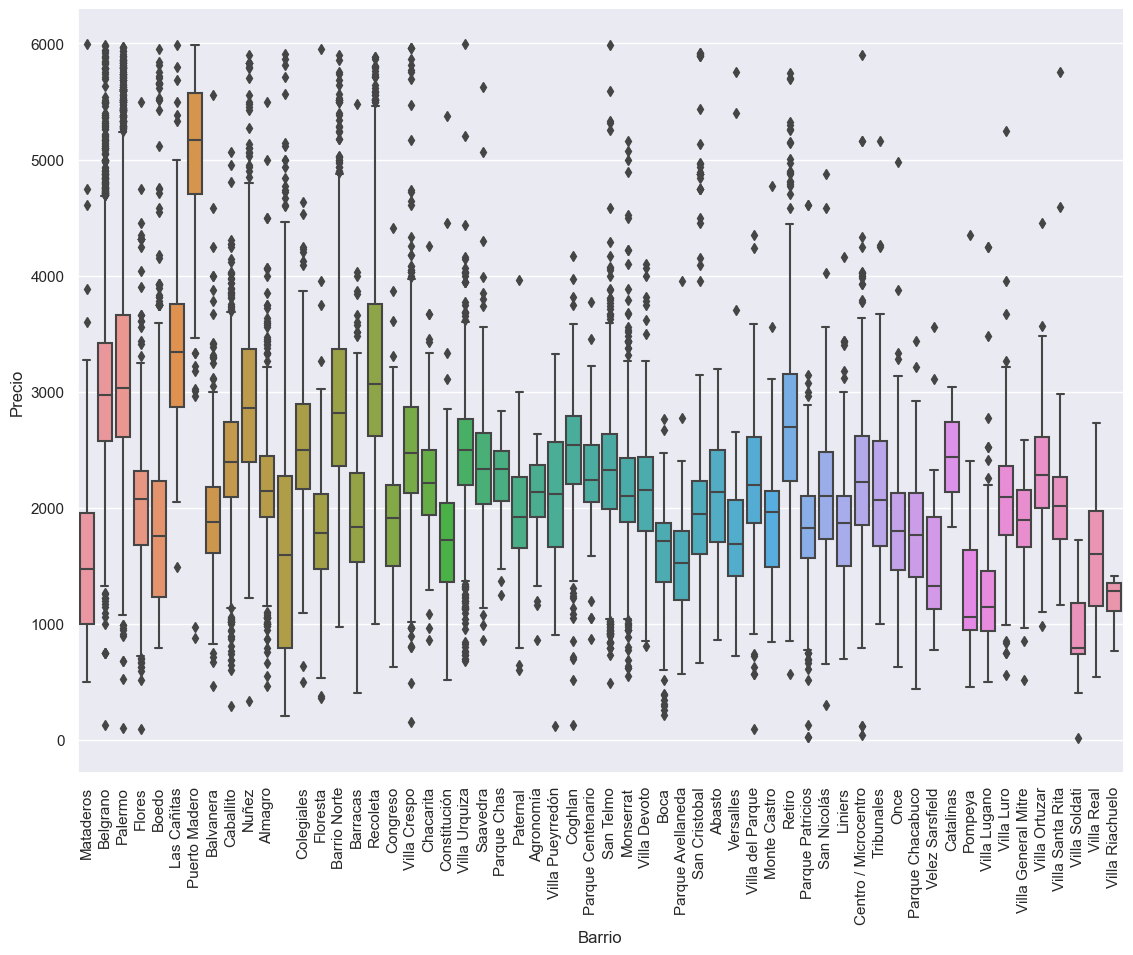

In [227]:
#Graficamos boxplot de cada barrio
g_box_barrio_caba_filtrado = sns.catplot(x = "barrio", y = "price_usd_per_m2", data=precio_barrio_caba_filtrado, kind="box",height=8.27, aspect=11.7/8.27)
g_box_barrio_caba_filtrado .set_axis_labels("Barrio", "Precio")  
g_box_barrio_caba_filtrado .set_xticklabels(rotation=90) 

## 4.3 Visualizamos la distribución de superficie total de las propiedades

Distribución de las superficies total de todas las propiedades

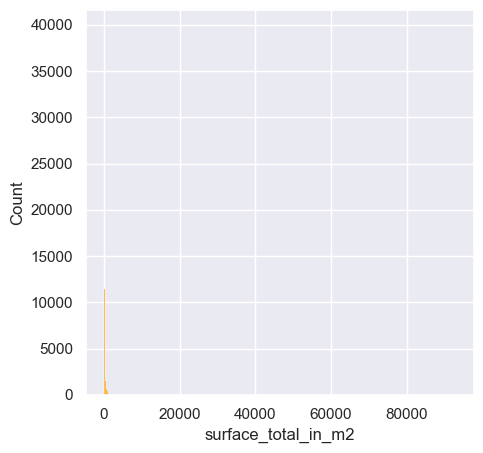

In [189]:
g_sup=sns.histplot(datos['surface_total_in_m2'], color = "orange", binwidth=100)

Visualizamos la distribución de superficie total de las propiedades aplicando un límite superior al eje X

[(0.0, 2000.0)]

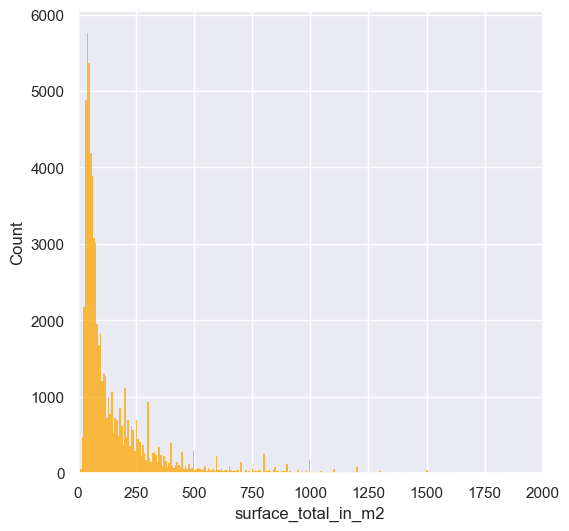

In [228]:
g_sup_filtrado=sns.histplot(datos['surface_total_in_m2'], color = "orange")#, binwidth=20)
g_sup_filtrado.set(xlim=(0,lim_sup_surface))

In [197]:
#Vemos los valores estadísticos de la superficie total de las propiedades
datos['surface_total_in_m2'].describe()

count    66002.000000
mean       176.489561
std        508.742520
min         10.000000
25%         50.000000
50%         81.000000
75%        192.000000
max      93000.000000
Name: surface_total_in_m2, dtype: float64

Veamos que valores tiene el top 10 de propiedades con mayor superficie

In [203]:
top10_superficie=datos.nlargest(10,'surface_total_in_m2')

display(top10_superficie[['ciudad','property_type','surface_total_in_m2','rooms','price_aprox_usd','price_usd_per_m2']])

ciudad property_type  surface_total_in_m2  rooms  \
106376  Lomas de Zamora         store              93000.0    NaN   
67857                           store              25000.0    NaN   
18746             Pilar         house              24000.0    6.0   
68655             Lanús         store              20500.0    NaN   
18987             Pilar         house              15000.0    NaN   
39810          Plottier            PH              14742.0    NaN   
65387          Necochea         store              14000.0    NaN   
67528        San Isidro         store              13200.0    NaN   
5131              Pilar         house              12200.0   10.0   
5132              Pilar         house              12200.0   10.0   

        price_aprox_usd  price_usd_per_m2  
106376        6000000.0         64.516129  
67857         1800000.0         72.000000  
18746          400000.0         16.666667  
68655         4500000.0        219.512195  
18987         1450000.0         96.666667  
39810          200000.0         13.566680  
65387         7200000.0        514.285714  
67528         8000000.0        606.060606  
5131           230000.0         18.852459  
5132           230000.0         18.852459

<AxesSubplot:xlabel='surface_total_in_m2', ylabel='Count'>

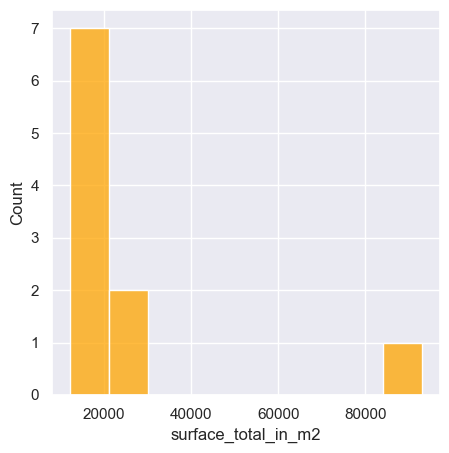

In [201]:
sns.histplot(top10_superficie['surface_total_in_m2'], color = "orange")#, binwidth=5000)

## 4.4 Visualizamos cantidades de propiedades publicadas según su tipo y ubicación geográfica



In [204]:
#creamos una lista con las primeras 10 provincias
lista_top_provincia=datos['provincia'].value_counts().index[:10].to_list()

#Usamos la lista para crear un dataframe filtrado
top_provincias= datos[datos['provincia'].isin(lista_top_provincia)]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Capital Federal'),
  Text(1, 0, 'Buenos Aires Costa Atlántica'),
  Text(2, 0, 'Bs.As. G.B.A. Zona Norte'),
  Text(3, 0, 'Bs.As. G.B.A. Zona Oeste'),
  Text(4, 0, 'Córdoba'),
  Text(5, 0, 'Bs.As. G.B.A. Zona Sur'),
  Text(6, 0, 'Santa Fe'),
  Text(7, 0, 'Buenos Aires Interior'),
  Text(8, 0, 'Mendoza'),
  Text(9, 0, 'Corrientes')])

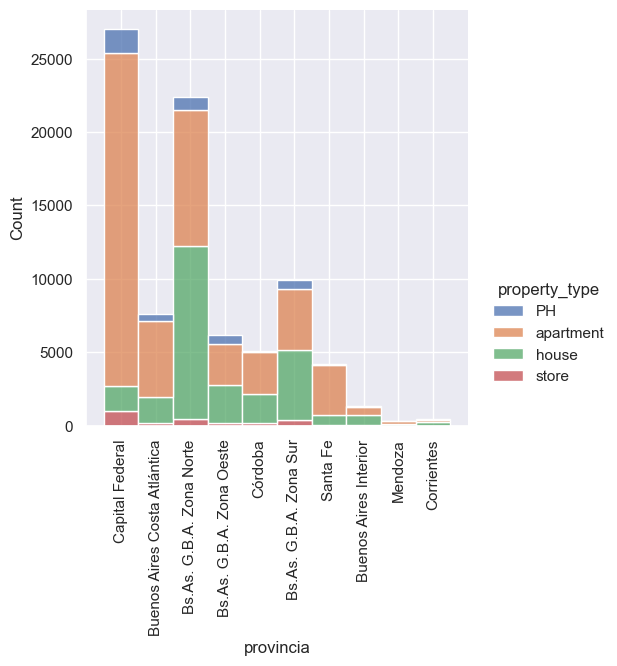

In [237]:
#Usamos una displot con stack 

g_prov_tipo=sns.displot(data=top_provincias, x="provincia", hue="property_type", multiple="stack", stat="count")
g_prov_tipo=sns.set(rc={'figure.figsize':(12,14)})
plt.xticks(rotation=90)



Visualizamos este top de provincias habiendo filtrado los outliers y utilizando boxplot

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Capital Federal'),
  Text(1, 0, 'Buenos Aires Costa Atlántica'),
  Text(2, 0, 'Bs.As. G.B.A. Zona Norte'),
  Text(3, 0, 'Bs.As. G.B.A. Zona Oeste'),
  Text(4, 0, 'Córdoba'),
  Text(5, 0, 'Bs.As. G.B.A. Zona Sur'),
  Text(6, 0, 'Santa Fe'),
  Text(7, 0, 'Buenos Aires Interior'),
  Text(8, 0, 'Mendoza'),
  Text(9, 0, 'Corrientes')])

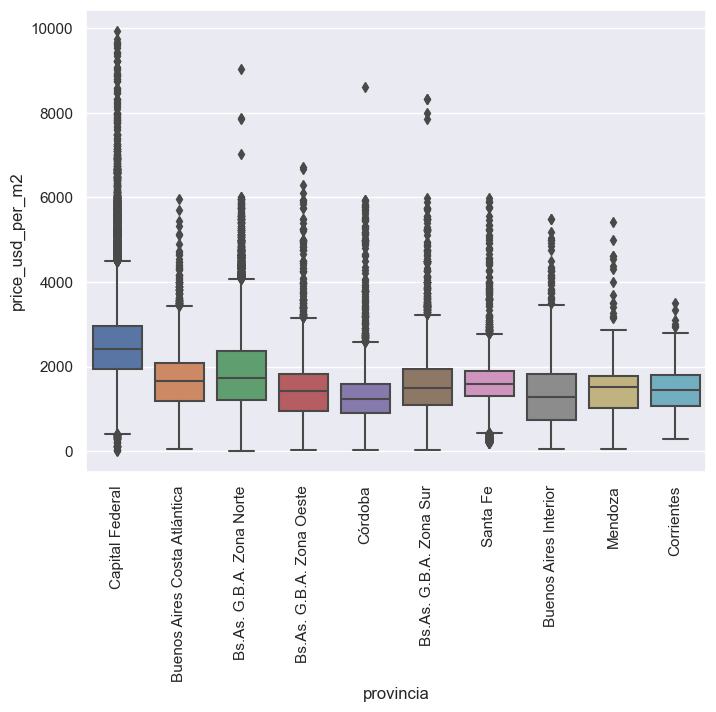

In [214]:
top_provincias_filtradas=top_provincias.loc[top_provincias['price_usd_per_m2']<10000]

plt.figure(figsize=(8, 6))

sns.boxplot(data=top_provincias_filtradas, x="provincia", y='price_usd_per_m2')#, hue="property_type")
plt.xticks(rotation=90)

### Realizamos la misma visualización para los barrios de CABA con mayor cantidad de propiedades publicadas

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Belgrano'),
  Text(1, 0, 'Palermo'),
  Text(2, 0, 'Flores'),
  Text(3, 0, 'Caballito'),
  Text(4, 0, 'Almagro'),
  Text(5, 0, 'Barrio Norte'),
  Text(6, 0, 'Recoleta'),
  Text(7, 0, 'Villa Crespo'),
  Text(8, 0, 'Villa Urquiza'),
  Text(9, 0, 'San Telmo')])

<Figure size 3000x2800 with 0 Axes>

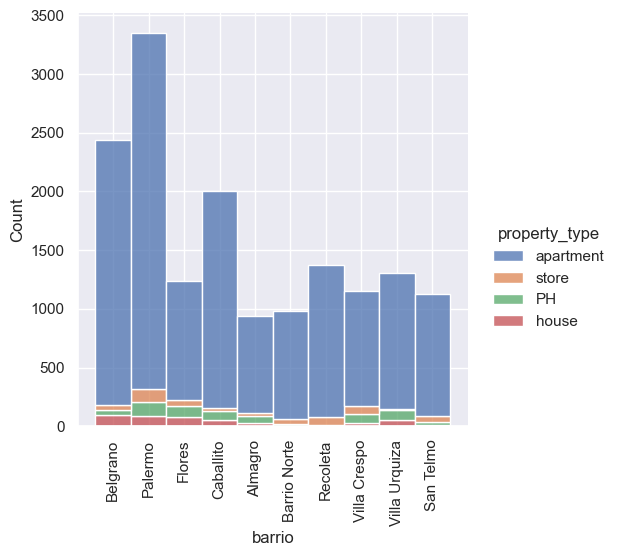

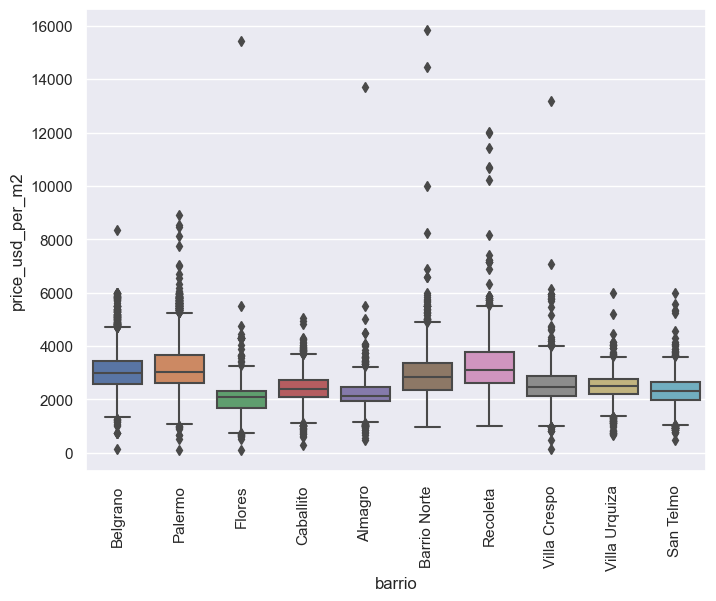

In [238]:
#Filtro aquellas propiedades que estan en caba
caba_filtrada=datos.loc[datos['ciudad']=='Capital Federal']

top_barrio_caba=caba_filtrada['barrio'].value_counts().index[:10].to_list()
#especies = arbolado['nombre_cientifico'].value_counts().index[:3].to_list()
#arbolado = arbolado[arbolado['nombre_cientifico'].isin(especies)]

top_caba= datos[datos['barrio'].isin(top_barrio_caba)]

#top_caba=datos['ciudad'].value_counts().index[:10].to_list()
top_caba_sin_vacios=top_caba.loc[top_caba['barrio']!='']
plt.figure(figsize=(30, 28))

sns.displot(data=top_caba_sin_vacios, x="barrio", hue="property_type", multiple="stack", stat="count")
plt.xticks(rotation=90)

plt.figure(figsize=(8, 6))

sns.boxplot(data=top_caba_sin_vacios, x="barrio", y='price_usd_per_m2')#, hue="property_type")
plt.xticks(rotation=90)


## 5- Análisis y Visualización Geográfica

<AxesSubplot:xlabel='lon', ylabel='lat'>

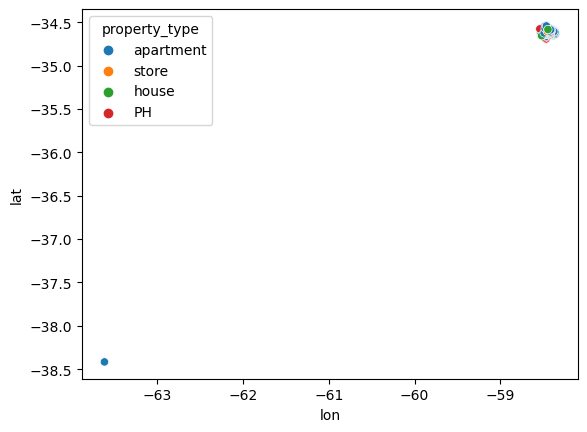

In [ ]:
sns.scatterplot(data = datos[datos["ciudad"] == "Capital Federal"].sample(1000), x="lon", y="lat",hue='property_type')

In [ ]:
comunas = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/comunas.csv")

#display (comunas.head())
#Trasnformamos la columna WKT
comunas["WKT"] = comunas["WKT"].apply(shapely.wkt.loads) 

#display(comunas.head())

# Creamos el GeoComunas
geo_comunas = gpd.GeoDataFrame(comunas, geometry='WKT')
#display (geo_comunas.head())

In [ ]:
geo_datos = gpd.GeoDataFrame(datos,geometry=gpd.points_from_xy(datos.lon, datos.lat))
geo_datos.head()

property_type        lat        lon  price_aprox_usd  surface_total_in_m2  \
0            PH -34.661824 -58.508839          62000.0                 55.0   
1     apartment -34.903883 -57.964330         150000.0                  NaN   
2     apartment -34.652262 -58.522982          72000.0                 55.0   
3            PH -34.647797 -58.516424          95000.0                  NaN   
4     apartment -38.002626 -57.549447          64000.0                 35.0   

   surface_covered_in_m2  price_usd_per_m2  price_per_m2  floor  rooms  ...  \
0                   40.0       1127.272727   1550.000000    NaN    NaN  ...   
1                    NaN               NaN           NaN    NaN    NaN  ...   
2                   55.0       1309.090909   1309.090909    NaN    NaN  ...   
3                    NaN               NaN           NaN    NaN    NaN  ...   
4                   35.0       1828.571429   1828.571429    NaN    NaN  ...   

            ciudad    barrio1 ambientes cochera parrilla  patio pileta  vista  \
0  Capital Federal  Mataderos       NaN   False    False  False  False  False   
1         La Plata                  NaN    True    False  False  False   True   
2  Capital Federal  Mataderos       NaN   False    False  False  False  False   
3  Capital Federal    Liniers         3   False    False   True  False  False   
4    Mar del Plata     Centro       NaN   False    False  False  False  False   

  usd_per_m2_2                     geometry  
0          NaN  POINT (-58.50884 -34.66182)  
1          NaN  POINT (-57.96433 -34.90388)  
2          NaN  POINT (-58.52298 -34.65226)  
3          NaN  POINT (-58.51642 -34.64780)  
4          NaN  POINT (-57.54945 -38.00263)  

[5 rows x 26 columns]

<AxesSubplot:>

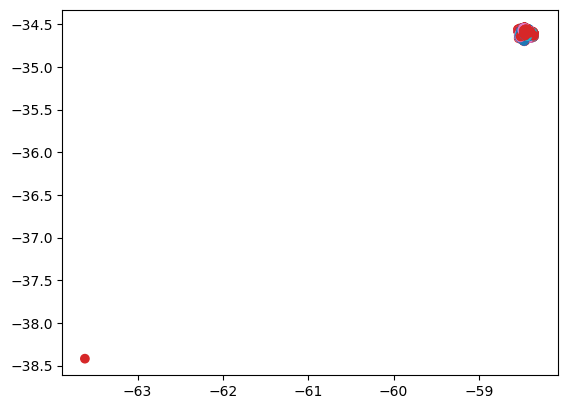

In [ ]:
fig, ax = plt.subplots()

#geo_arboles.sample(1000).plot(ax=ax, column = "nombre_cientifico")
geo_comunas.plot(ax=ax, facecolor="none", edgecolor='black')
geo_datos.loc[geo_datos['ciudad']=='Capital Federal'].plot(ax=ax, column='property_type')


In [ ]:
#Vemos que hay un valor erroneo, no esta en capital federal su ubicación de lat lon
propiedades_caba=geo_datos.loc[geo_datos['ciudad']=='Capital Federal']

In [ ]:
lejanas=propiedades_caba.lat < -38

In [ ]:
caba_cercanas=propiedades_caba.lat > -38

In [ ]:
caba_grafico=propiedades_caba.loc[caba_cercanas]
caba_grafico.head()

property_type        lat        lon  price_aprox_usd  surface_total_in_m2  \
0            PH -34.661824 -58.508839          62000.0                 55.0   
2     apartment -34.652262 -58.522982          72000.0                 55.0   
3            PH -34.647797 -58.516424          95000.0                  NaN   
7     apartment -34.559873 -58.443362         138000.0                 45.0   
8     apartment -34.559873 -58.443362         195000.0                 65.0   

   surface_covered_in_m2  price_usd_per_m2  price_per_m2  floor  rooms  ...  \
0                   40.0       1127.272727   1550.000000    NaN    NaN  ...   
2                   55.0       1309.090909   1309.090909    NaN    NaN  ...   
3                    NaN               NaN           NaN    NaN    NaN  ...   
7                   40.0       3066.666667   3450.000000    NaN    NaN  ...   
8                   60.0       3000.000000   3250.000000    NaN    NaN  ...   

            ciudad    barrio1 ambientes cochera parrilla  patio pileta  vista  \
0  Capital Federal  Mataderos       NaN   False    False  False  False  False   
2  Capital Federal  Mataderos       NaN   False    False  False  False  False   
3  Capital Federal    Liniers         3   False    False   True  False  False   
7  Capital Federal   Belgrano       NaN   False    False  False  False  False   
8  Capital Federal   Belgrano       NaN   False    False  False  False  False   

  usd_per_m2_2                     geometry  
0          NaN  POINT (-58.50884 -34.66182)  
2          NaN  POINT (-58.52298 -34.65226)  
3          NaN  POINT (-58.51642 -34.64780)  
7          NaN  POINT (-58.44336 -34.55987)  
8          NaN  POINT (-58.44336 -34.55987)  

[5 rows x 26 columns]

<AxesSubplot:>

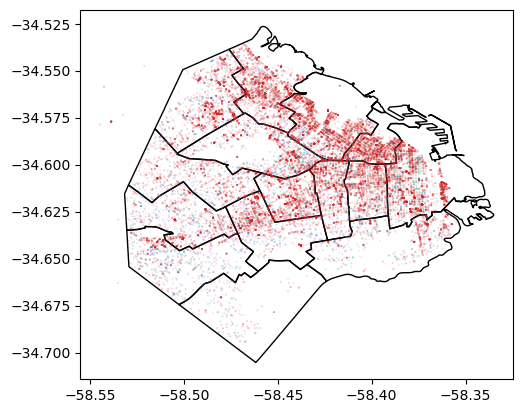

In [ ]:
fig, ax = plt.subplots()

#geo_arboles.sample(1000).plot(ax=ax, column = "nombre_cientifico")
geo_comunas.plot(ax=ax, facecolor="none", edgecolor='black')
caba_grafico.loc[caba_grafico['ciudad']=='Capital Federal'].plot(ax=ax, column='property_type',markersize=0.1,marker='o',alpha=0.3)

In [ ]:
display(propiedades_caba[lejanas])


property_type        lat        lon  price_aprox_usd  \
28512     apartment -38.416097 -63.616672          45000.0   

       surface_total_in_m2  surface_covered_in_m2  price_usd_per_m2  \
28512                 70.0                   70.0        642.857143   

       price_per_m2  floor  rooms  ...           ciudad    barrio1 ambientes  \
28512    642.857143    NaN    3.0  ...  Capital Federal  Mataderos       NaN   

      cochera parrilla  patio pileta  vista usd_per_m2_2  \
28512   False    False  False  False  False          NaN   

                          geometry  
28512  POINT (-63.61667 -38.41610)  

[1 rows x 26 columns]

In [ ]:
datos.loc[28512]

property_type                                                    apartment
lat                                                               -38.4161
lon                                                               -63.6167
price_aprox_usd                                                      45000
surface_total_in_m2                                                     70
surface_covered_in_m2                                                   70
price_usd_per_m2                                                   642.857
price_per_m2                                                       642.857
floor                                                                  NaN
rooms                                                                    3
expenses                                                               NaN
properati_url            http://www.properati.com.ar/17wcl_venta_depart...
description              Dueño directo vende departamento de 3 amb. amp...
title                    

In [ ]:


#df = pd.read_csv('df.csv')
px
fig = px.scatter(data_frame = datos, x = "price_aprox_usd", y = "surface_total_in_m2",
                 opacity = 0.6,
                 width=1000, height=700)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
fig = px.scatter(Top_filtrada, x = 'price_aprox_usd', y = 'surface_total_in_m2'
                , facet_col_wrap = 3,facet_col='provincia')
fig.show()